# Código inicial

In [1]:
import os

os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 
#-----The part above is to avoid a warning from the system, but I failed... again.

import numpy as np #-------------------------------------------------------------Calculos cientificos
import pandas as pd #------------------------------------------------------------Analisis de datos
import matplotlib.pyplot as plt #------------------------------------------------Creacion de graficos
from sklearn.cluster import KMeans #---------------------------------------------K-means
from sklearn.datasets import make_blobs #----------------------------------------Convinient way to generate synthetic clusters
from sklearn.metrics import silhouette_score #-----------------------------------Used in Silhouette method.

#---------------DATOS USANDO PANDAS----------------
X_com=pd.read_csv ('C:/Users/alide/OneDrive/Escritorio/SS/CDMX/503a709995fc7000c61360f4533f40c8/591108_22.17_-100.94_1998.csv' , engine='python') 
#We put the rute of the file but with / instead of \, keep that in mind

#En este caso, GHI esta en la col de latitude y asi sucesivamente. Escojo los datos que usaré cada que lo necesite.
#X_com.head() me deja ver los primeros 5 datos.
X_com.rename(columns={'Source': 'Year','Location ID':'Month','City':'Day','State':'Hour','Country':'Minute',
                      'Latitude': 'GHI','Longitude':'Temperature','Time Zone':'Wind Speed','Elevation': 'Wind Direction'}, inplace=True)

#------------CREAMOS LOS DIAS--------------
X_com['Year'] = X_com['Year'].astype("string")
X_com['Month'] = X_com['Month'].astype("string")
X_com['Day'] = X_com['Day'].astype("string")
X_com['Hour'] = X_com['Hour'].astype("string") 
X_com['Minute'] = X_com['Minute'].astype("string")

#Agrego los valores para poder tener el formato de dia.
X_com['Date'] =X_com['Day'] + '/' + X_com['Month'] + '/' + X_com['Year']

X_Dias = pd.DataFrame()
X_Dias['Date'] = X_com['Date']
X_Dias = X_Dias.drop([0])
X_Dias = X_Dias.drop_duplicates()
X_Dias.reset_index(drop=True, inplace=True) #necesario para que los indices no cambiaran al final.
X_Dias = X_Dias.drop([0]) #necesario para que los indices no cambiaran al final.


#-----------Sigo con los datos
X_com['GHI'] = pd.to_numeric(X_com['GHI'], errors='coerce')
X_com['Temperature'] = pd.to_numeric(X_com['Temperature'], errors='coerce')
X_com['Wind Speed'] = pd.to_numeric(X_com['Wind Speed'], errors='coerce')
X_com['Wind Direction'] = pd.to_numeric(X_com['Wind Direction'], errors='coerce')

X_com = X_com.loc[:,['GHI', 'Temperature','Wind Speed']]
#X_com.info()  #Para ver la info del archivo importado. Las variables deben ser numéricas para hacer el cloustering


#--------------------------MULTIPLICAMOS GHI POR INTERVALOS DE TIEMPO PARA LA ENERGÍA SOLAR----------

X_com['GHIxIntTiempo'] = X_com['GHI'].mul(0.5*0.2) #El 0.2 es del 20 porciento de la eficiencia. Este dato puede cambiar


#--------------------------ENUMERO LOS DÍAS DEL 1 AL 365--------
if len(X_com['GHI']) > 48*365:
    diasaño = 367
else: 
    diasaño = 366

X_com['Day Num.'] = ''
for i in range (1 , diasaño ): 
    for j in range(2+48*(i-1), 2 + 48*i):
        X_com.at[j, 'Day Num.'] = i


#--------------------------DATOS DE LAS HORAS DEL SOL------------------------------------------------
X_com_GHI_Year = X_com.loc[(X_com['GHI'] >  0)]

#--------------------------CREO NUEVOS DATOS CON LOS PROMEDIOS DIARIOS DE CADA COLUMNA EN HORAS DE SOL---------------
X_GHI_Year = pd.DataFrame()
X_GHI_Year['Date'] = X_Dias['Date']
X_GHI_Year['GHI'] = X_com_GHI_Year.groupby('Day Num.')['GHI'].agg('mean')
X_GHI_Year['Temperature'] = X_com_GHI_Year.groupby('Day Num.')['Temperature'].mean()
X_GHI_Year['Wind Speed'] = X_com_GHI_Year.groupby('Day Num.')['Wind Speed'].mean()
X_GHI_Year['WS_Dia_Comp'] = X_com.groupby('Day Num.')['Wind Speed'].agg('mean')


#--------------------------ENERGIA EÓLICA HORAS DE SOL---------------------------------
#defino constantes: OJO, rho depende de T, pero por ahora lo tomamos como cte.
#AQUI CAMBIO UNIDADES TAMBIEN A M/S EN WS!!
rho = 0.96   #kg/m3
A_Rotor = 1  #m3 puedo cambiar este dato dependiendo del rotor.

X_GHI_Year['Energia_E_Sol'] = ((X_GHI_Year['Wind Speed'] / 3.6) ** 3) * rho * A_Rotor / 2 


#--------------------------ENERGIA EÓLICA TODO EL DIA---------------------------------

X_GHI_Year['Energia_E_Dia_Comp'] = ((X_GHI_Year['WS_Dia_Comp'] / 3.6) ** 3) * rho * A_Rotor / 2  #queda en unidades de A al cuadrado.


#--------------------------PROMEDIO ENERGÍA SOLAR CON EFICIENCIA----------------------
X_GHI_Year['Energia_S'] = X_com_GHI_Year.groupby('Day Num.')['GHIxIntTiempo'].mean()


#X_GHI_Year.drop(X_GHI_Year.tail(1).index,inplace=True) # quito la última fila, no se xq sale.
#X_GHI_Year.info()
#X_GHI_Year.head(5)


#----------TEMPERATURA AMBIENTE PROMEDIO ANUAL DURANTE HORAS DE SOL (obtenidas mediante promedio delas temperaturas)-------
X_TempAmbProm_Year = X_GHI_Year['Temperature'].sum() / len(X_GHI_Year['Temperature'])


#--------------------------NORMALIZO LOS DATOS--------------------------------------------------------
X_GHI_Year['GHI_norm']=(X_GHI_Year['GHI']-X_GHI_Year['GHI'].min())/(X_GHI_Year['GHI'].max()-X_GHI_Year['GHI'].min())#Here I did it correctly.
X_GHI_Year['T_norm']=(X_GHI_Year['Temperature']-X_GHI_Year['Temperature'].min())/(X_GHI_Year['Temperature'].max()-X_GHI_Year['Temperature'].min())
X_GHI_Year['V_norm']=(X_GHI_Year['Wind Speed']-X_GHI_Year['Wind Speed'].min())/(X_GHI_Year['Wind Speed'].max()-X_GHI_Year['Wind Speed'].min())
X_GHI_Year['Energia_E_Sol_norm']=(X_GHI_Year['Energia_E_Sol']-X_GHI_Year['Energia_E_Sol'].min())/(X_GHI_Year['Energia_E_Sol'].max()-X_GHI_Year['Energia_E_Sol'].min())
X_GHI_Year['Energia_E_Dia_Comp_norm']=(X_GHI_Year['Energia_E_Dia_Comp']-X_GHI_Year['Energia_E_Dia_Comp'].min())/(X_GHI_Year['Energia_E_Dia_Comp'].max()-X_GHI_Year['Energia_E_Dia_Comp'].min())
X_GHI_Year['Energia_S_norm'] = (X_GHI_Year['Energia_S']-X_GHI_Year['Energia_S'].min())/(X_GHI_Year['Energia_S'].max()-X_GHI_Year['Energia_S'].min())

print('Normalized data statistics')
print(X_GHI_Year.describe())

Normalized data statistics
              GHI  Temperature  Wind Speed  WS_Dia_Comp  Energia_E_Sol  \
count  365.000000   365.000000  365.000000   365.000000     365.000000   
mean   545.152854    22.795174    3.878225     3.103099       0.887944   
std    105.941197     4.087106    1.466661     1.107907       1.194282   
min    221.619048    12.352174    1.495238     1.287500       0.034393   
25%    476.791667    20.190476    2.757143     2.258333       0.215631   
50%    554.904762    22.530435    3.703846     2.920833       0.522748   
75%    637.086957    25.200000    4.688000     3.791667       1.059977   
max    724.666667    32.523077    9.695652     8.112500       9.377019   

       Energia_E_Dia_Comp   Energia_S    GHI_norm      T_norm      V_norm  \
count          365.000000  365.000000  365.000000  365.000000  365.000000   
mean             0.437180   54.515285    0.643147    0.517726    0.290593   
std              0.554296   10.594120    0.210599    0.202624    0.178852  

# CLUSTERS GHI, T, WS

## 1D tomando horas de sol

### GHI

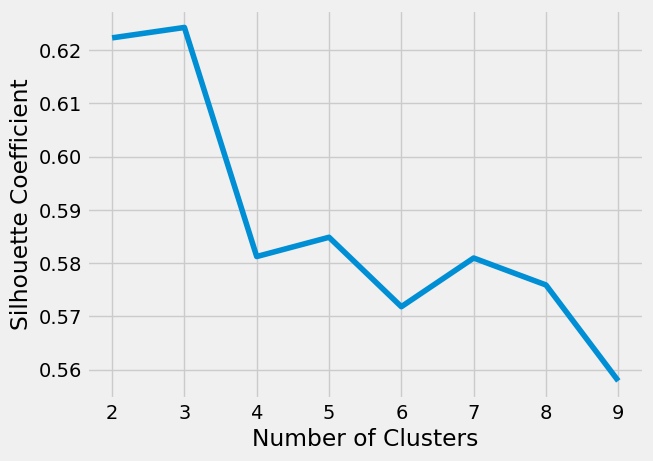

The SS of 0.624 gives the best k at k = 3


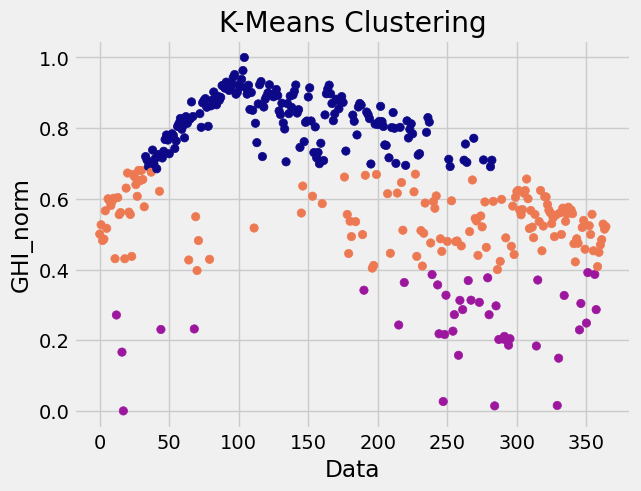

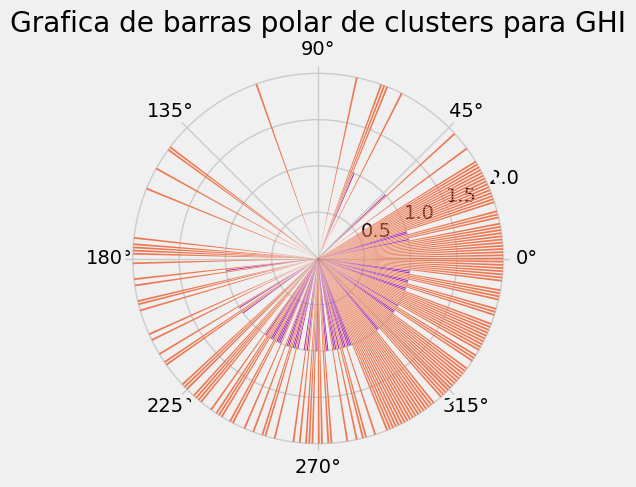

Cluster 0 va de 566.217 a 724.667 W/m^2
Cluster 1 va de 221.619 a 418.476 W/m^2
Cluster 2 va de 421.435 a 563.905 W/m^2


In [2]:
#--------Checking for the best k using Silhouette method.
# A list holds the silhouette coefficients for each k
X = X_GHI_Year['GHI_norm'].to_numpy()
X = X.reshape(-1,1)

silhouette_coefficients = []

for k in range(2,10): 
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42) 
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)
 
#plotting the different SS.
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#Analyzing the graph
def max_ss(list):
    for i, item in enumerate(list):
        if item == max(list):
            return i
    return None

best_k = max_ss(silhouette_coefficients)+2 #Will be used for the K-mean method later on.
# The '+3' comes from the way we build the method starting in 3.

print(f"The SS of {max(silhouette_coefficients):.3f} gives the best k at k = {best_k}") 

#-----------Fit K-means Model
# Create a k-means instance with k clusters.
kmeans = KMeans(n_clusters=best_k, n_init=10, max_iter=300)
kmeans.fit(X)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_


#----------Visualize Clusters

# Scatter plot of data points
#It changes to this expression using x points as indexes and y points as the real values X
colors = plt.cm.plasma(labels / best_k)
plt.scatter([i for i in range(len(X))], X, color=colors) #FOR 1D CLUSTERING ONLY

# Plot cluster centers
#plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=50, label='Cluster Centers')
#I dont know how to plot centers in a 1D clustering

plt.xlabel('Data')  #Change accordingly
plt.ylabel('GHI_norm')  #Change accordingly
plt.title('K-Means Clustering')
plt.show()


#-----------Agrego los resultados del clustering en la tabla. Yo puedo escoger el destino.
X_GHI_Year.loc[:,'GHI_Cluster'] = labels


#https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_bar.html
#------- Compute pie slices
N = 365
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = labels
width = 0.01

ax = plt.subplot(projection='polar')
ax.set_rticks([0.5, 1, 1.5, 2])
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=1)
ax.set_title('Grafica de barras polar de clusters para GHI')
plt.show()

#---------Cluster ranges
for i in range(0,best_k):
    Cluster_i = X_GHI_Year.loc[X_GHI_Year['GHI_Cluster'] == i, ['GHI', 'GHI_Cluster']]
    print(f"Cluster {i} va de {min(Cluster_i['GHI']):.3f} a {max(Cluster_i['GHI']):.3f} W/m^2")

#### Tabla con fechas

In [3]:
ClustersA = []
ClustersB = []
ClustersC = []
ClustersD = []
ClustersE=[]
LimitesA = []
LimitesB = []
LimitesC = []
LimitesD = []
LimitesE = []

X_GHI_Fechas_Clusters = pd.DataFrame()
Inicio = []
Fin = []
N_Cluster = []




for j in range(1, diasaño-1):
    if X_GHI_Year['GHI_Cluster'][j] == 0:
        ClustersA.append(int(j))
    elif X_GHI_Year['GHI_Cluster'][j] == 1: 
        ClustersB.append(int(j))
    elif X_GHI_Year['GHI_Cluster'][j] == 2: 
        ClustersC.append(int(j))
    elif X_GHI_Year['GHI_Cluster'][j] == 3: 
        ClustersD.append(int(j))
    elif X_GHI_Year['GHI_Cluster'][j] == 4: 
        ClustersE.append(int(j))
    else: 
        None

for k in range(0, len(ClustersA)):
    if ClustersA[k-1] < ClustersA[k] & ClustersA[k] < ClustersA[k-1] + 2: 
        None
    else:
        LimitesA.append(ClustersA[k-1]) , LimitesA.append(ClustersA[k])


for k in range(0, len(ClustersB)):
    if ClustersB[k-1] < ClustersB[k] & ClustersB[k] < ClustersB[k-1] + 2: 
        None
    else:
        LimitesB.append(ClustersB[k-1]) , LimitesB.append(ClustersB[k])

for k in range(0, len(ClustersC)):
    if ClustersC[k-1] < ClustersC[k] & ClustersC[k] < ClustersC[k-1] + 2: 
        None
    else:
        LimitesC.append(ClustersC[k-1]) , LimitesC.append(ClustersC[k])

for k in range(0, len(ClustersD)):
    if ClustersD[k-1] < ClustersD[k] & ClustersD[k] < ClustersD[k-1] + 2: 
        None
    else:
        LimitesD.append(ClustersD[k-1]) , LimitesD.append(ClustersD[k])

for k in range(0, len(ClustersE)):
    if ClustersE[k-1] < ClustersE[k] & ClustersE[k] < ClustersE[k-1] + 2: 
        None
    else:
        LimitesE.append(ClustersE[k-1]) , LimitesE.append(ClustersE[k])


Limites = LimitesA + LimitesB + LimitesC + LimitesD + LimitesE
Limites.sort()

#print(LimitesA)    
#print(LimitesB)
#print(LimitesC)
#print(LimitesD)
#print(LimitesE)
#print(Limites)
#len(Limites)

for i in range(0,len(Limites)):
    if i == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    elif i % 2 == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    else: 
        Fin.append(X_GHI_Year['Date'][Limites[i]]) ,
        N_Cluster.append(X_GHI_Year['GHI_Cluster'][Limites[i]])


#len(N_Cluster)
#len(Inicio)
#len(Fin)

X_GHI_Fechas_Clusters['Inicia'] = Inicio
X_GHI_Fechas_Clusters['Termina'] = Fin
X_GHI_Fechas_Clusters['No. de Cluster'] = N_Cluster  

X_GHI_Fechas_Clusters

Inicia     Termina  No. de Cluster
0      1/1/1998   12/1/1998               2
1     13/1/1998   13/1/1998               1
2     14/1/1998   16/1/1998               2
3     17/1/1998   18/1/1998               1
4     19/1/1998    2/2/1998               2
..          ...         ...             ...
97   14/12/1998  16/12/1998               2
98   17/12/1998  18/12/1998               1
99   19/12/1998  22/12/1998               2
100  23/12/1998  24/12/1998               1
101  25/12/1998  31/12/1998               2

[102 rows x 3 columns]

### Temperatura

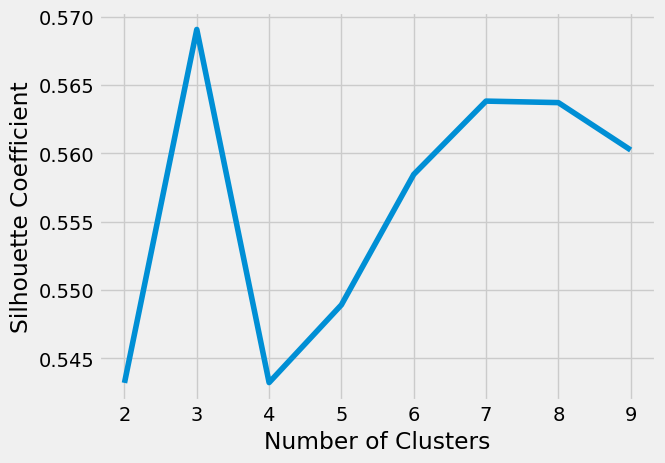

The SS of 0.569 gives the best k at k = 3


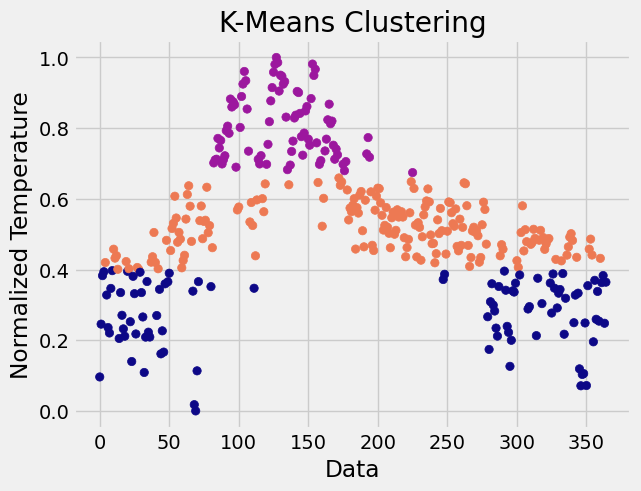

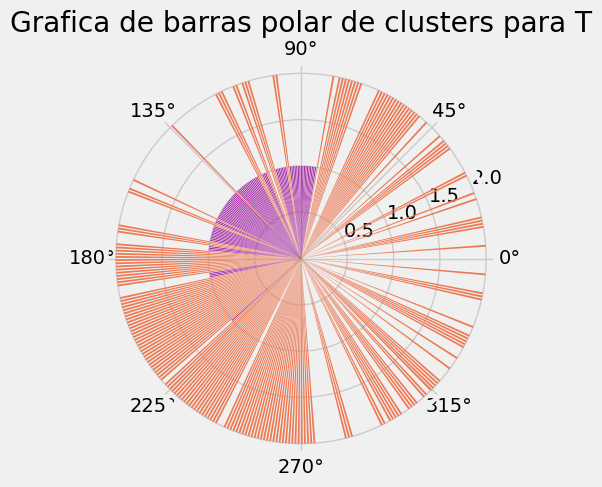

Cluster 0 va de 12.352 a 20.357 °C
Cluster 1 va de 25.954 a 32.523 °C
Cluster 2 va de 20.433 a 25.646 °C


In [4]:
#--------Checking for the best k using Silhouette method.
# A list holds the silhouette coefficients for each k
X = X_GHI_Year['T_norm'].to_numpy()
X = X.reshape(-1,1)

silhouette_coefficients = []

for k in range(2,10): 
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42) 
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)
 
#plotting the different SS.
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#Analyzing the graph
def max_ss(list):
    for i, item in enumerate(list):
        if item == max(list):
            return i
    return None

best_k = max_ss(silhouette_coefficients)+2 #Will be used for the K-mean method later on.
# The '+3' comes from the way we build the method starting in 3.
print(f"The SS of {max(silhouette_coefficients):.3f} gives the best k at k = {best_k}") 


#-----------Fit K-means Model
# Create a k-means instance with k clusters.
kmeans = KMeans(n_clusters=best_k, n_init=10, max_iter=300)
kmeans.fit(X)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_


#----------Visualize Clusters
# Scatter plot of data points

#It changes to this expression using x points as indexes and y points as the real values X
colors = plt.cm.plasma(labels/best_k)
plt.scatter([i for i in range(len(X))], X, color=colors) #FOR 1D CLUSTERING, THE SCATTER CHANGES

# Plot cluster centers
#plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=50, label='Cluster Centers')
#I dont know hot to plot centers in a 1D clustering

plt.xlabel('Data')  #Change accordingly
plt.ylabel('Normalized Temperature')  #Change accordingly
plt.title('K-Means Clustering') 
plt.show()

#-----------Agrego los resultados del clustering en la tabla. Yo puedo escoger el destino.
X_GHI_Year.loc[:,'T_Cluster'] = labels


#https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_bar.html
#------- Compute pie slices
N = 365
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = labels
width = 0.01

ax = plt.subplot(projection='polar')
ax.set_rticks([0.5, 1, 1.5, 2])
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=1)
ax.set_title('Grafica de barras polar de clusters para T')
plt.show()

#---------Cluster ranges
for i in range(0,best_k):
    Cluster_i = X_GHI_Year.loc[X_GHI_Year['T_Cluster'] == i, ['Temperature', 'T_Cluster']]
    print(f"Cluster {i} va de {min(Cluster_i['Temperature']):.3f} a {max(Cluster_i['Temperature']):.3f} °C")

#### Tabla con fechas

In [5]:
ClustersA = []
ClustersB = []
ClustersC = []
ClustersD = []
ClustersE=[]
LimitesA = []
LimitesB = []
LimitesC = []
LimitesD = []
LimitesE = []

X_T_Fechas_Clusters = pd.DataFrame()
Inicio = []
Fin = []
N_Cluster = []




for j in range(1, diasaño-1):
    if X_GHI_Year['T_Cluster'][j] == 0:
        ClustersA.append(int(j))
    elif X_GHI_Year['T_Cluster'][j] == 1: 
        ClustersB.append(int(j))
    elif X_GHI_Year['T_Cluster'][j] == 2: 
        ClustersC.append(int(j))
    elif X_GHI_Year['T_Cluster'][j] == 3: 
        ClustersD.append(int(j))
    elif X_GHI_Year['T_Cluster'][j] == 4: 
        ClustersE.append(int(j))
    else: 
        None

for k in range(0, len(ClustersA)):
    if ClustersA[k-1] < ClustersA[k] & ClustersA[k] < ClustersA[k-1] + 2: 
        None
    else:
        LimitesA.append(ClustersA[k-1]) , LimitesA.append(ClustersA[k])


for k in range(0, len(ClustersB)):
    if ClustersB[k-1] < ClustersB[k] & ClustersB[k] < ClustersB[k-1] + 2: 
        None
    else:
        LimitesB.append(ClustersB[k-1]) , LimitesB.append(ClustersB[k])

for k in range(0, len(ClustersC)):
    if ClustersC[k-1] < ClustersC[k] & ClustersC[k] < ClustersC[k-1] + 2: 
        None
    else:
        LimitesC.append(ClustersC[k-1]) , LimitesC.append(ClustersC[k])

for k in range(0, len(ClustersD)):
    if ClustersD[k-1] < ClustersD[k] & ClustersD[k] < ClustersD[k-1] + 2: 
        None
    else:
        LimitesD.append(ClustersD[k-1]) , LimitesD.append(ClustersD[k])

for k in range(0, len(ClustersE)):
    if ClustersE[k-1] < ClustersE[k] & ClustersE[k] < ClustersE[k-1] + 2: 
        None
    else:
        LimitesE.append(ClustersE[k-1]) , LimitesE.append(ClustersE[k])


Limites = LimitesA + LimitesB + LimitesC + LimitesD + LimitesE
Limites.sort()

#print(LimitesA)    
#print(LimitesB)
#print(LimitesC)
#print(LimitesD)
#print(LimitesE)
#print(Limites)
#len(Limites)

for i in range(0,len(Limites)):
    if i == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    elif i % 2 == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    else: 
        Fin.append(X_GHI_Year['Date'][Limites[i]]) ,
        N_Cluster.append(X_GHI_Year['T_Cluster'][Limites[i]])


#len(N_Cluster)
#len(Inicio)
#len(Fin)

X_T_Fechas_Clusters['Inicia'] = Inicio
X_T_Fechas_Clusters['Termina'] = Fin
X_T_Fechas_Clusters['No. de Cluster'] = N_Cluster  

X_T_Fechas_Clusters

Inicia     Termina  No. de Cluster
0     1/1/1998    4/1/1998               0
1     5/1/1998    5/1/1998               2
2     6/1/1998   10/1/1998               0
3    11/1/1998   14/1/1998               2
4    15/1/1998   19/1/1998               0
..         ...         ...             ...
66  11/12/1998  18/12/1998               0
67  19/12/1998  21/12/1998               2
68  22/12/1998  26/12/1998               0
69  27/12/1998  27/12/1998               2
70  28/12/1998  31/12/1998               0

[71 rows x 3 columns]

### Velocidad del viento

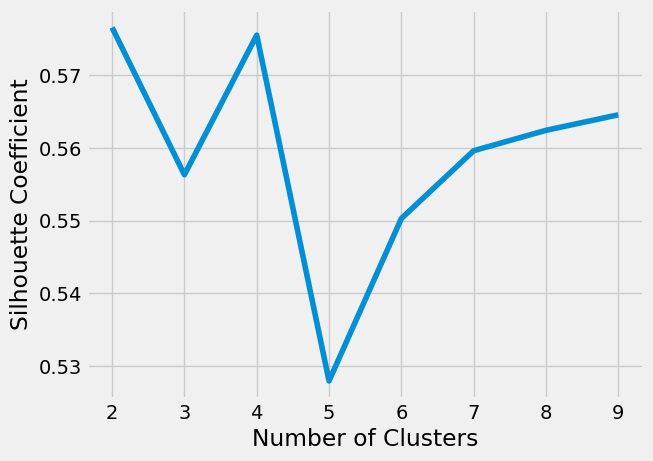

The SS of 0.577 gives the best k at k = 2


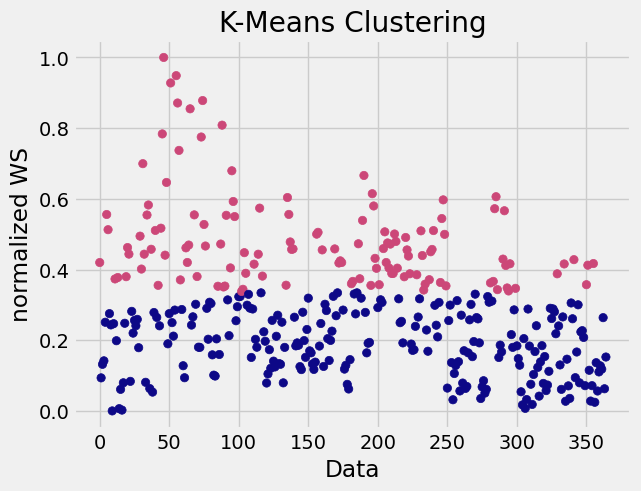

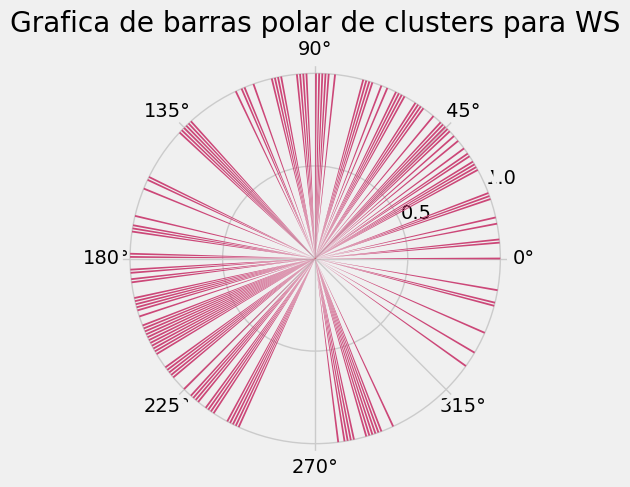

Cluster 0 va de 1.495 a 4.235 km/hr
Cluster 1 va de 4.267 a 9.696 km/hr


In [6]:
#--------Checking for the best k using Silhouette method.
# A list holds the silhouette coefficients for each k
X = X_GHI_Year['V_norm'].to_numpy()
X = X.reshape(-1,1)

silhouette_coefficients = []

for k in range(2,10): 
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42) 
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)
 
#plotting the different SS.
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#Analyzing the graph
def max_ss(list):
    for i, item in enumerate(list):
        if item == max(list):
            return i
    return None

best_k = max_ss(silhouette_coefficients)+2 #Will be used for the K-mean method later on.
# The '+3' comes from the way we build the method starting in 3.

print(f"The SS of {max(silhouette_coefficients):.3f} gives the best k at k = {best_k}") 

#-----------Fit K-means Model
# Create a k-means instance with k clusters.
kmeans = KMeans(n_clusters=best_k, n_init=10, max_iter=300)
kmeans.fit(X)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_


#----------Visualize Clusters
# Scatter plot of data points

#It changes to this expression using x points as indexes and y points as the real values X
colors = plt.cm.plasma(labels / best_k)
plt.scatter([i for i in range(len(X))], X, c=colors) #FOR 1D CLUSTERING, THE SCATTER CHANGES

# Plot cluster centers
#plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=50, label='Cluster Centers')
#I dont know hot to plot centers in a 1D clustering

plt.xlabel('Data')  #Change accordingly
plt.ylabel('normalized WS')  #Change accordingly
plt.title('K-Means Clustering') 
plt.show()

#-----------Agrego los resultados del clustering en la tabla. Yo puedo escoger el destino.
X_GHI_Year.loc[:,'WS_Cluster'] = labels

#X_GHI_Year


#https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_bar.html
#------- Compute pie slices
N = 365
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = labels
width = 0.01

ax = plt.subplot(projection='polar')
ax.set_rticks([0.5, 1, 1.5, 2])
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=1)
ax.set_title('Grafica de barras polar de clusters para WS')
plt.show()


#---------Cluster ranges
for i in range(0,best_k):
    Cluster_i = X_GHI_Year.loc[X_GHI_Year['WS_Cluster'] == i, ['Wind Speed', 'WS_Cluster']]
    print(f"Cluster {i} va de {min(Cluster_i['Wind Speed']):.3f} a {max(Cluster_i['Wind Speed']):.3f} km/hr")

#### Tabla con fechas

In [7]:
ClustersA = []
ClustersB = []
ClustersC = []
ClustersD = []
ClustersE=[]
LimitesA = []
LimitesB = []
LimitesC = []
LimitesD = []
LimitesE = []

X_WS_Fechas_Clusters = pd.DataFrame()
Inicio = []
Fin = []
N_Cluster = []




for j in range(1, diasaño-1):
    if X_GHI_Year['WS_Cluster'][j] == 0:
        ClustersA.append(int(j))
    elif X_GHI_Year['WS_Cluster'][j] == 1: 
        ClustersB.append(int(j))
    elif X_GHI_Year['WS_Cluster'][j] == 2: 
        ClustersC.append(int(j))
    elif X_GHI_Year['WS_Cluster'][j] == 3: 
        ClustersD.append(int(j))
    elif X_GHI_Year['WS_Cluster'][j] == 4: 
        ClustersE.append(int(j))
    else: 
        None

for k in range(0, len(ClustersA)):
    if ClustersA[k-1] < ClustersA[k] & ClustersA[k] < ClustersA[k-1] + 2: 
        None
    else:
        LimitesA.append(ClustersA[k-1]) , LimitesA.append(ClustersA[k])


for k in range(0, len(ClustersB)):
    if ClustersB[k-1] < ClustersB[k] & ClustersB[k] < ClustersB[k-1] + 2: 
        None
    else:
        LimitesB.append(ClustersB[k-1]) , LimitesB.append(ClustersB[k])

for k in range(0, len(ClustersC)):
    if ClustersC[k-1] < ClustersC[k] & ClustersC[k] < ClustersC[k-1] + 2: 
        None
    else:
        LimitesC.append(ClustersC[k-1]) , LimitesC.append(ClustersC[k])

for k in range(0, len(ClustersD)):
    if ClustersD[k-1] < ClustersD[k] & ClustersD[k] < ClustersD[k-1] + 2: 
        None
    else:
        LimitesD.append(ClustersD[k-1]) , LimitesD.append(ClustersD[k])

for k in range(0, len(ClustersE)):
    if ClustersE[k-1] < ClustersE[k] & ClustersE[k] < ClustersE[k-1] + 2: 
        None
    else:
        LimitesE.append(ClustersE[k-1]) , LimitesE.append(ClustersE[k])


Limites = LimitesA + LimitesB + LimitesC + LimitesD + LimitesE
Limites.sort()

#print(LimitesA)    
#print(LimitesB)
#print(LimitesC)
#print(LimitesD)
#print(LimitesE)
#print(Limites)
#len(Limites)

for i in range(0,len(Limites)):
    if i == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    elif i % 2 == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    else: 
        Fin.append(X_GHI_Year['Date'][Limites[i]]) ,
        N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])


#len(N_Cluster)
#len(Inicio)
#len(Fin)

X_WS_Fechas_Clusters['Inicia'] = Inicio
X_WS_Fechas_Clusters['Termina'] = Fin
X_WS_Fechas_Clusters['No. de Cluster'] = N_Cluster  

X_WS_Fechas_Clusters

Inicia     Termina  No. de Cluster
0     1/1/1998    1/1/1998               1
1     2/1/1998    5/1/1998               0
2     6/1/1998    7/1/1998               1
3     8/1/1998   11/1/1998               0
4    12/1/1998   12/1/1998               1
..         ...         ...             ...
93   9/12/1998  16/12/1998               0
94  17/12/1998  18/12/1998               1
95  19/12/1998  21/12/1998               0
96  22/12/1998  22/12/1998               1
97  23/12/1998  31/12/1998               0

[98 rows x 3 columns]

## Clusters 2-D (tomando horas de sol)

### Para GHI y Temperatura

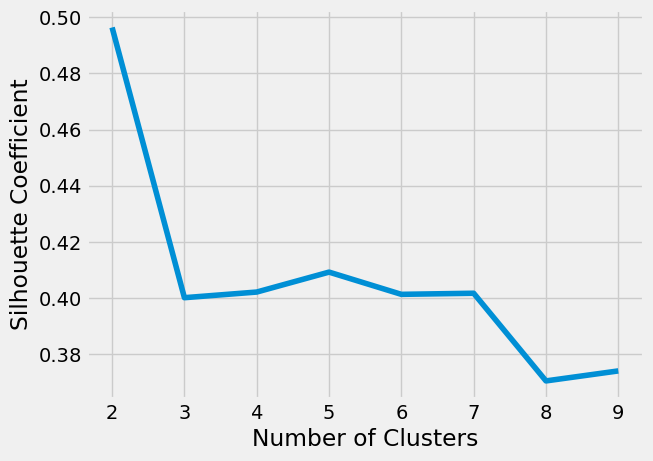

The SS of 0.496 gives the best k at k = 2


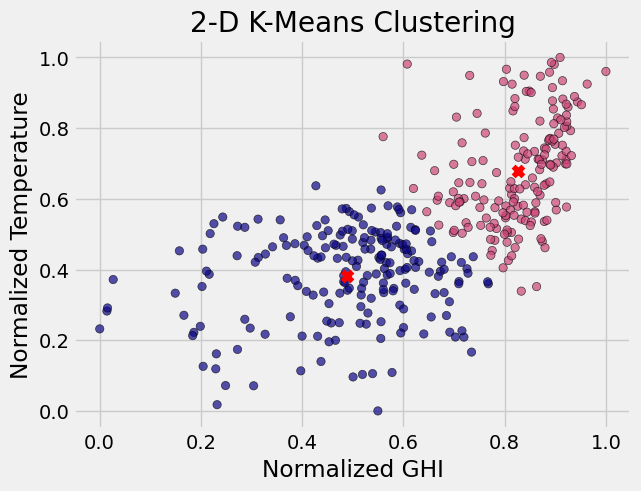

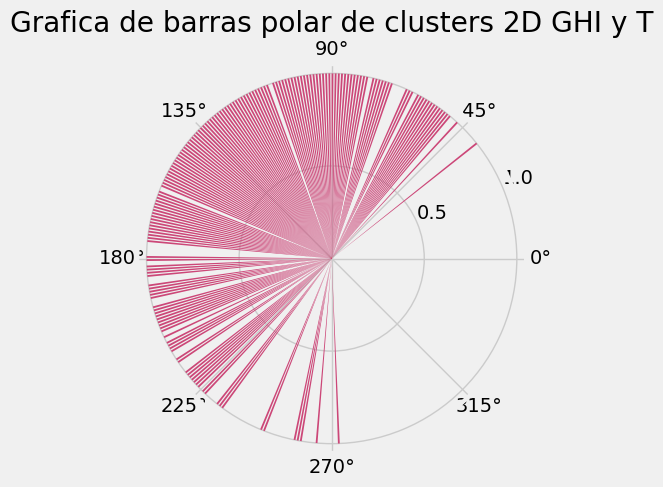

Cluster 0 va de 12.352 a 25.200 °C
y de 221.619 a 607.826 W/m^2

Cluster 1 va de 19.187 a 32.523 °C
y de 503.269 a 724.667 W/m^2



In [8]:
#--------Checking for the best k using Silhouette method.
# A list holds the silhouette coefficients for each k
X = X_GHI_Year.loc[:,'GHI_norm':'T_norm']
X = X.to_numpy()

silhouette_coefficients = []

for k in range(2,10): 
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42) 
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)
 
#plotting the different SS.
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#Analyzing the graph
def max_ss(list):
    for i, item in enumerate(list):
        if item == max(list):
            return i
    return None

best_k = max_ss(silhouette_coefficients)+2 #Will be used for the K-mean method later on.
# The '+3' comes from the way we build the method starting in 3.

print(f"The SS of {max(silhouette_coefficients):.3f} gives the best k at k = {best_k}") 


#-----------Fit K-means Model
# Create a k-means instance with k clusters.
kmeans = KMeans(n_clusters=best_k, n_init=10, max_iter=300)
kmeans.fit(X)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_


#----------Visualize Clusters
# Scatter plot of data points

#It changes to this expression using x points as indexes and y points as the real values X
colors = plt.cm.plasma(labels / best_k)
plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.7, edgecolors='k')

#---------Plot cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=50, label='Cluster Centers')
#I dont know hot to plot centers in a 1D clustering

plt.xlabel('Normalized GHI')  #Change accordingly
plt.ylabel('Normalized Temperature')  #Change accordingly
plt.title('2-D K-Means Clustering') 
plt.show()


#-----------Agrego los resultados del clustering en la tabla. Yo puedo escoger el destino.
X_GHI_Year.loc[:,'GHI_T_Cluster'] = labels


#https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_bar.html
#------- Compute pie slices
N = 365
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = labels
width = 0.01

ax = plt.subplot(projection='polar')
ax.set_rticks([0.5, 1, 1.5, 2])
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=1)
ax.set_title('Grafica de barras polar de clusters 2D GHI y T')
plt.show()

#---------Cluster ranges
for i in range(0,best_k):
    Cluster_i = X_GHI_Year.loc[X_GHI_Year['GHI_T_Cluster'] == i, ['GHI', 'Temperature', 'GHI_T_Cluster']]
    print(f"Cluster {i} va de {min(Cluster_i['Temperature']):.3f} a {max(Cluster_i['Temperature']):.3f} °C")
    print(f"y de {min(Cluster_i['GHI']):.3f} a {max(Cluster_i['GHI']):.3f} W/m^2")
    print()

#### Tabla con fechas

In [9]:
ClustersA = []
ClustersB = []
ClustersC = []
ClustersD = []
ClustersE=[]
LimitesA = []
LimitesB = []
LimitesC = []
LimitesD = []
LimitesE = []

X_GHI_T_Fechas_Clusters = pd.DataFrame()
Inicio = []
Fin = []
N_Cluster = []




for j in range(1, diasaño-1):
    if X_GHI_Year['GHI_T_Cluster'][j] == 0:
        ClustersA.append(int(j))
    elif X_GHI_Year['GHI_T_Cluster'][j] == 1: 
        ClustersB.append(int(j))
    elif X_GHI_Year['GHI_T_Cluster'][j] == 2: 
        ClustersC.append(int(j))
    elif X_GHI_Year['GHI_T_Cluster'][j] == 3: 
        ClustersD.append(int(j))
    elif X_GHI_Year['GHI_T_Cluster'][j] == 4: 
        ClustersE.append(int(j))
    else: 
        None

for k in range(0, len(ClustersA)):
    if ClustersA[k-1] < ClustersA[k] & ClustersA[k] < ClustersA[k-1] + 2: 
        None
    else:
        LimitesA.append(ClustersA[k-1]) , LimitesA.append(ClustersA[k])


for k in range(0, len(ClustersB)):
    if ClustersB[k-1] < ClustersB[k] & ClustersB[k] < ClustersB[k-1] + 2: 
        None
    else:
        LimitesB.append(ClustersB[k-1]) , LimitesB.append(ClustersB[k])

for k in range(0, len(ClustersC)):
    if ClustersC[k-1] < ClustersC[k] & ClustersC[k] < ClustersC[k-1] + 2: 
        None
    else:
        LimitesC.append(ClustersC[k-1]) , LimitesC.append(ClustersC[k])

for k in range(0, len(ClustersD)):
    if ClustersD[k-1] < ClustersD[k] & ClustersD[k] < ClustersD[k-1] + 2: 
        None
    else:
        LimitesD.append(ClustersD[k-1]) , LimitesD.append(ClustersD[k])

for k in range(0, len(ClustersE)):
    if ClustersE[k-1] < ClustersE[k] & ClustersE[k] < ClustersE[k-1] + 2: 
        None
    else:
        LimitesE.append(ClustersE[k-1]) , LimitesE.append(ClustersE[k])


Limites = LimitesA + LimitesB + LimitesC + LimitesD + LimitesE
Limites.sort()

#print(LimitesA)    
#print(LimitesB)
#print(LimitesC)
#print(LimitesD)
#print(LimitesE)
#print(Limites)
#len(Limites)

for i in range(0,len(Limites)):
    if i == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    elif i % 2 == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    else: 
        Fin.append(X_GHI_Year['Date'][Limites[i]]) ,
        N_Cluster.append(X_GHI_Year['GHI_T_Cluster'][Limites[i]])


#len(N_Cluster)
#len(Inicio)
#len(Fin)

X_GHI_T_Fechas_Clusters['Inicia'] = Inicio
X_GHI_T_Fechas_Clusters['Termina'] = Fin
X_GHI_T_Fechas_Clusters['No. de Cluster'] = N_Cluster  

X_GHI_T_Fechas_Clusters

Inicia     Termina  No. de Cluster
0    1/1/1998    8/2/1998               0
1    9/2/1998    9/2/1998               1
2   10/2/1998   17/2/1998               0
3   18/2/1998   18/2/1998               1
4   19/2/1998   20/2/1998               0
5   21/2/1998    5/3/1998               1
6    6/3/1998    6/3/1998               0
7    7/3/1998    9/3/1998               1
8   10/3/1998   13/3/1998               0
9   14/3/1998   20/3/1998               1
10  21/3/1998   21/3/1998               0
11  22/3/1998   21/4/1998               1
12  22/4/1998   22/4/1998               0
13  23/4/1998    9/6/1998               1
14  10/6/1998   10/6/1998               0
15  11/6/1998   27/6/1998               1
16  28/6/1998    1/7/1998               0
17   2/7/1998    3/7/1998               1
18   4/7/1998    4/7/1998               0
19   5/7/1998    8/7/1998               1
20   9/7/1998   10/7/1998               0
21  11/7/1998   15/7/1998               1
22  16/7/1998   17/7/1998               0
23  18/7/1998   26/7/1998               1
24  27/7/1998   27/7/1998               0
25  28/7/1998   28/7/1998               1
26  29/7/1998   29/7/1998               0
27  30/7/1998    2/8/1998               1
28   3/8/1998    4/8/1998               0
29   5/8/1998    6/8/1998               1
30   7/8/1998    9/8/1998               0
31  10/8/1998   16/8/1998               1
32  17/8/1998   17/8/1998               0
33  18/8/1998   19/8/1998               1
34  20/8/1998   23/8/1998               0
35  24/8/1998   26/8/1998               1
36  27/8/1998    8/9/1998               0
37   9/9/1998   10/9/1998               1
38  11/9/1998   19/9/1998               0
39  20/9/1998   22/9/1998               1
40  23/9/1998   26/9/1998               0
41  27/9/1998   27/9/1998               1
42  28/9/1998   3/10/1998               0
43  4/10/1998   4/10/1998               1
44  5/10/1998  31/12/1998               0

### Para Temperatura y Velocidad del viento

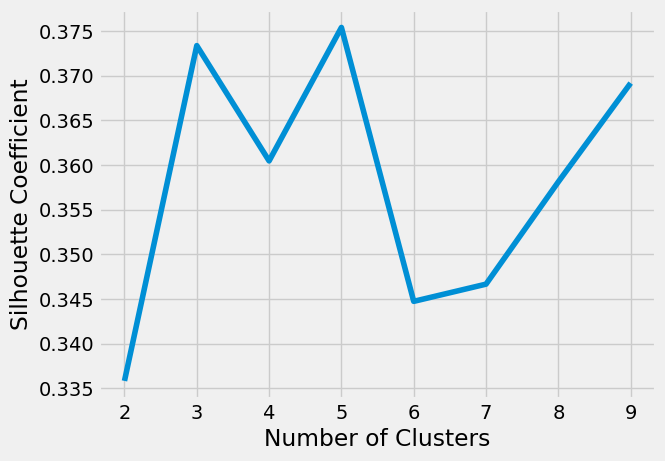

The SS of 0.375 gives the best k at k = 5


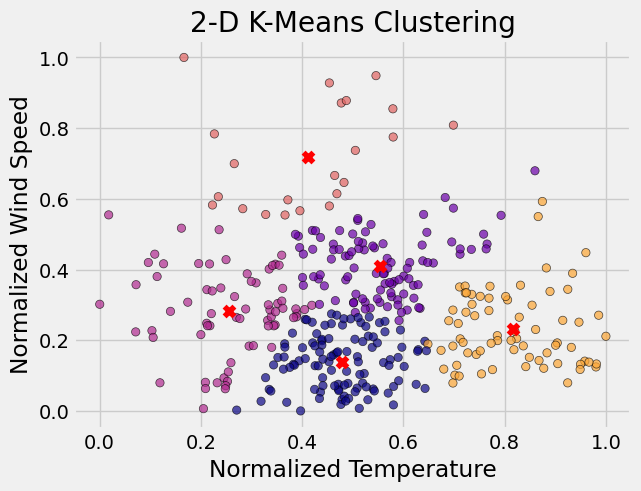

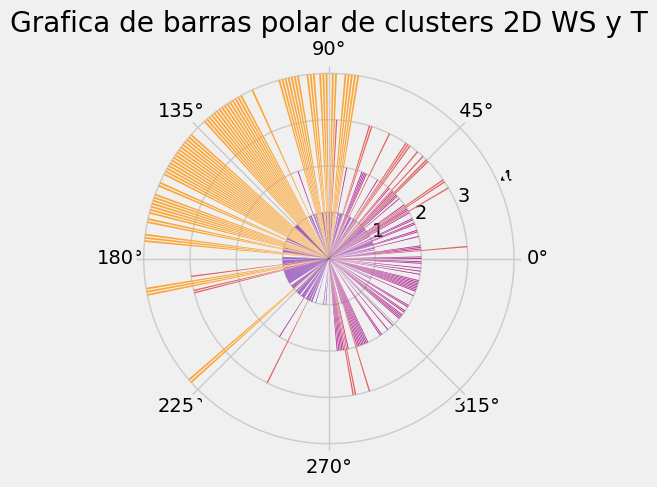

Cluster 0 va de 17.810 a 25.371 °C
y de 1.495 a 3.746  km/hr

Cluster 1 va de 20.150 a 29.696 °C
y de 3.592 a 7.067  km/hr

Cluster 2 va de 12.352 a 20.804 °C
y de 1.548 a 6.043  km/hr

Cluster 3 va de 15.709 a 26.446 °C
y de 6.041 a 9.696  km/hr

Cluster 4 va de 25.431 a 32.523 °C
y de 2.142 a 6.354  km/hr



In [10]:
#--------Checking for the best k using Silhouette method.
# A list holds the silhouette coefficients for each k
X = X_GHI_Year.loc[:,'T_norm':'V_norm']
X = X.to_numpy()

silhouette_coefficients = []

for k in range(2,10): 
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42) 
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)
 
#plotting the different SS.
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#Analyzing the graph
def max_ss(list):
    for i, item in enumerate(list):
        if item == max(list):
            return i
    return None

best_k = max_ss(silhouette_coefficients)+2 #Will be used for the K-mean method later on.
# The '+3' comes from the way we build the method starting in 3.

print(f"The SS of {max(silhouette_coefficients):.3f} gives the best k at k = {best_k}") 


#-----------Fit K-means Model
# Create a k-means instance with k clusters.
kmeans = KMeans(n_clusters=best_k, n_init=10, max_iter=300)
kmeans.fit(X)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_


#----------Visualize Clusters
# Scatter plot of data points

#It changes to this expression using x points as indexes and y points as the real values X
colors = plt.cm.plasma(labels / best_k)
plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.7, edgecolors='k')

#---------Plot cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=50, label='Cluster Centers')
#I dont know hot to plot centers in a 1D clustering

plt.xlabel('Normalized Temperature')  #Change accordingly
plt.ylabel('Normalized Wind Speed')  #Change accordingly
plt.title('2-D K-Means Clustering') 
plt.show()

#-----------Agrego los resultados del clustering en la tabla. Yo puedo escoger el destino.
X_GHI_Year.loc[:,'T_WS_Cluster'] = labels


#https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_bar.html
#-----------Compute pie slices
N = 365
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = labels
width = 0.01

ax = plt.subplot(projection='polar')
ax.set_rticks([1,2,3,4,5])
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=1)
ax.set_title('Grafica de barras polar de clusters 2D WS y T')
plt.show()

#---------Cluster ranges
for i in range(0,best_k):
    Cluster_i = X_GHI_Year.loc[X_GHI_Year['T_WS_Cluster'] == i, ['Wind Speed', 'Temperature', 'T_WS_Cluster']]
    print(f"Cluster {i} va de {min(Cluster_i['Temperature']):.3f} a {max(Cluster_i['Temperature']):.3f} °C")
    print(f"y de {min(Cluster_i['Wind Speed']):.3f} a {max(Cluster_i['Wind Speed']):.3f}  km/hr")
    print()

#### Tabla con fechas

In [11]:
ClustersA = []
ClustersB = []
ClustersC = []
ClustersD = []
ClustersE=[]
LimitesA = []
LimitesB = []
LimitesC = []
LimitesD = []
LimitesE = []

X_T_WS_Fechas_Clusters = pd.DataFrame()
Inicio = []
Fin = []
N_Cluster = []




for j in range(1, diasaño-1):
    if X_GHI_Year['T_WS_Cluster'][j] == 0:
        ClustersA.append(int(j))
    elif X_GHI_Year['T_WS_Cluster'][j] == 1: 
        ClustersB.append(int(j))
    elif X_GHI_Year['T_WS_Cluster'][j] == 2: 
        ClustersC.append(int(j))
    elif X_GHI_Year['T_WS_Cluster'][j] == 3: 
        ClustersD.append(int(j))
    elif X_GHI_Year['T_WS_Cluster'][j] == 4: 
        ClustersE.append(int(j))
    else: 
        None

for k in range(0, len(ClustersA)):
    if ClustersA[k-1] < ClustersA[k] & ClustersA[k] < ClustersA[k-1] + 2: 
        None
    else:
        LimitesA.append(ClustersA[k-1]) , LimitesA.append(ClustersA[k])


for k in range(0, len(ClustersB)):
    if ClustersB[k-1] < ClustersB[k] & ClustersB[k] < ClustersB[k-1] + 2: 
        None
    else:
        LimitesB.append(ClustersB[k-1]) , LimitesB.append(ClustersB[k])

for k in range(0, len(ClustersC)):
    if ClustersC[k-1] < ClustersC[k] & ClustersC[k] < ClustersC[k-1] + 2: 
        None
    else:
        LimitesC.append(ClustersC[k-1]) , LimitesC.append(ClustersC[k])

for k in range(0, len(ClustersD)):
    if ClustersD[k-1] < ClustersD[k] & ClustersD[k] < ClustersD[k-1] + 2: 
        None
    else:
        LimitesD.append(ClustersD[k-1]) , LimitesD.append(ClustersD[k])

for k in range(0, len(ClustersE)):
    if ClustersE[k-1] < ClustersE[k] & ClustersE[k] < ClustersE[k-1] + 2: 
        None
    else:
        LimitesE.append(ClustersE[k-1]) , LimitesE.append(ClustersE[k])


Limites = LimitesA + LimitesB + LimitesC + LimitesD + LimitesE
Limites.sort()

#print(LimitesA)    
#print(LimitesB)
#print(LimitesC)
#print(LimitesD)
#print(LimitesE)
#print(Limites)
#len(Limites)

for i in range(0,len(Limites)):
    if i == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    elif i % 2 == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    else: 
        Fin.append(X_GHI_Year['Date'][Limites[i]]) ,
        N_Cluster.append(X_GHI_Year['T_WS_Cluster'][Limites[i]])


#len(N_Cluster)
#len(Inicio)
#len(Fin)

X_T_WS_Fechas_Clusters['Inicia'] = Inicio
X_T_WS_Fechas_Clusters['Termina'] = Fin
X_T_WS_Fechas_Clusters['No. de Cluster'] = N_Cluster  

X_T_WS_Fechas_Clusters

Inicia     Termina  No. de Cluster
0      1/1/1998    2/1/1998               2
1      3/1/1998    5/1/1998               0
2      6/1/1998    6/1/1998               3
3      7/1/1998    9/1/1998               2
4     10/1/1998   11/1/1998               0
..          ...         ...             ...
144  25/12/1998  25/12/1998               0
145  26/12/1998  26/12/1998               2
146  27/12/1998  28/12/1998               0
147  29/12/1998  30/12/1998               2
148  31/12/1998  31/12/1998               0

[149 rows x 3 columns]

### Para GHI y Velocidad del viento

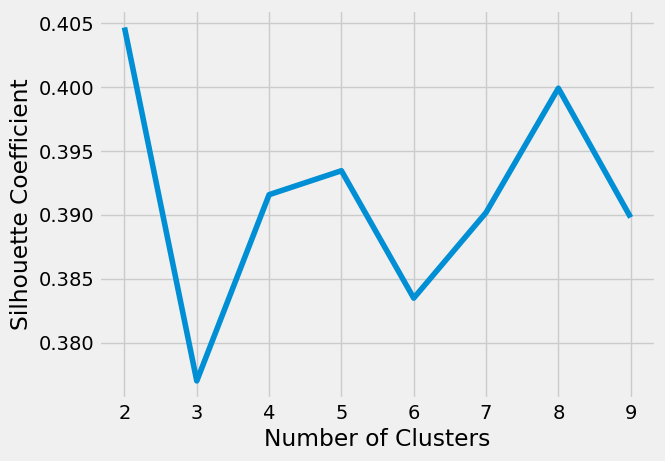

The SS of 0.405 gives the best k at k = 2


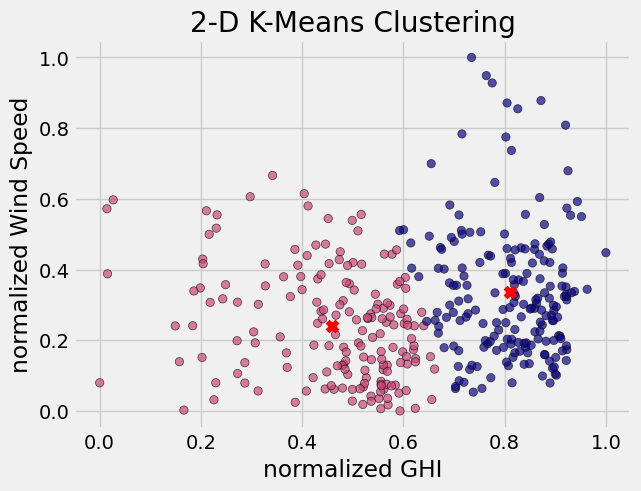

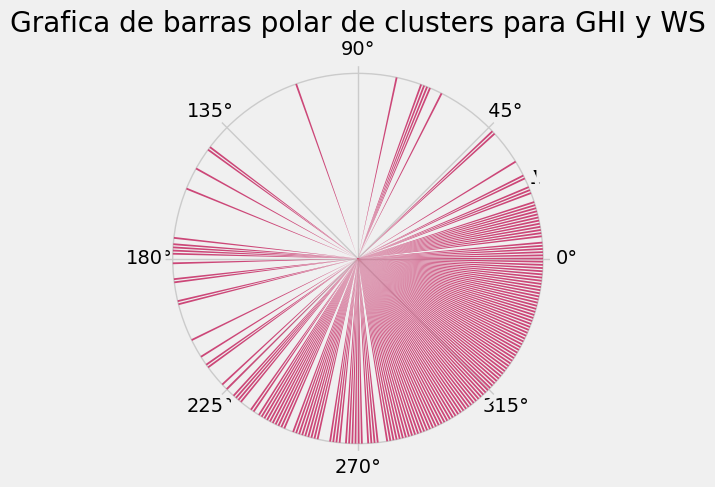

Cluster 0 va de 519.583 a 724.667 W/m^2
y de 1.932 a 9.696 km/hr

Cluster 1 va de 221.619 a 554.462 W/m^2
y de 1.495 a 6.958 km/hr



In [12]:
#--------Checking for the best k using Silhouette method.
# A list holds the silhouette coefficients for each k

X = X_GHI_Year[['GHI_norm','V_norm']]
X = X.to_numpy()

silhouette_coefficients = []

for k in range(2,10): 
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42) 
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)
 
#plotting the different SS.
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#Analyzing the graph
def max_ss(list):
    for i, item in enumerate(list):
        if item == max(list):
            return i
    return None

best_k = max_ss(silhouette_coefficients)+2 #Will be used for the K-mean method later on.
# The '+3' comes from the way we build the method starting in 3.

print(f"The SS of {max(silhouette_coefficients):.3f} gives the best k at k = {best_k}") 


#-----------Fit K-means Model
# Create a k-means instance with k clusters.
kmeans = KMeans(n_clusters=best_k, n_init=10, max_iter=300)
kmeans.fit(X)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_


#----------Visualize Clusters
# Scatter plot of data points

#It changes to this expression using x points as indexes and y points as the real values X
colors = plt.cm.plasma(labels / best_k)
plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.7, edgecolors='k')

#---------Plot cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=50, label='Cluster Centers')
#I dont know hot to plot centers in a 1D clustering

plt.xlabel('normalized GHI')  #Change accordingly
plt.ylabel('normalized Wind Speed')  #Change accordingly
plt.title('2-D K-Means Clustering') 
plt.show()

#-----------Agrego los resultados del clustering en la tabla. Yo puedo escoger el destino.
X_GHI_Year.loc[:,'GHI_WS_Cluster'] = labels


#https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_bar.html
#------- Compute pie slices
N = 365
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = labels
width = 0.01

ax = plt.subplot(projection='polar')
ax.set_rticks([1,2])
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=1)
ax.set_title('Grafica de barras polar de clusters para GHI y WS')
plt.show()

#---------Cluster ranges
for i in range(0,best_k):
    Cluster_i = X_GHI_Year.loc[X_GHI_Year['GHI_WS_Cluster'] == i, ['Wind Speed', 'GHI', 'GHI_WS_Cluster']]
    print(f"Cluster {i} va de {min(Cluster_i['GHI']):.3f} a {max(Cluster_i['GHI']):.3f} W/m^2")
    print(f"y de {min(Cluster_i['Wind Speed']):.3f} a {max(Cluster_i['Wind Speed']):.3f} km/hr")
    print()

#### Tabla con fechas

In [13]:
ClustersA = []
ClustersB = []
LimitesA = []
LimitesB = []

X_GHI_WS_Fechas_Clusters = pd.DataFrame()
Inicio = []
Fin = []
N_Cluster = [i % 2 for i in range(61)]


for i in range(0,1):
    for j in range(1, diasaño-1):
        if X_GHI_Year['GHI_WS_Cluster'][j] == i:
            ClustersA.append(int(j))
        else: ClustersB.append(int(j))


for k in range(0, len(ClustersA)):
    if ClustersA[k-1] < ClustersA[k] & ClustersA[k] < ClustersA[k-1] + 2: 
        None
    else:
        LimitesA.append(ClustersA[k-1]) , LimitesA.append(ClustersA[k])


for k in range(0, len(ClustersB)):
    if ClustersB[k-1] < ClustersB[k] & ClustersB[k] < ClustersB[k-1] + 2: 
        None
    else:
        LimitesB.append(ClustersB[k-1]) , LimitesB.append(ClustersB[k])
        
#print(LimitesA)    
#print(LimitesB)

Limites = LimitesA + LimitesB
Limites.sort()
#print(Limites)
#len(Limites)

for i in range(0,len(Limites)):
    if i == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    elif i % 2 == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    else: 
        Fin.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])

#len(Fin)
#len(Inicio)
#print(Fin)

X_GHI_WS_Fechas_Clusters['Inicia'] = Inicio
X_GHI_WS_Fechas_Clusters['Termina'] = Fin
X_GHI_WS_Fechas_Clusters['No. de Cluster'] = N_Cluster  

X_GHI_WS_Fechas_Clusters

Inicia     Termina  No. de Cluster
0     1/1/1998    6/1/1998               0
1     7/1/1998    7/1/1998               1
2     8/1/1998   19/1/1998               0
3    20/1/1998   21/1/1998               1
4    22/1/1998   24/1/1998               0
..         ...         ...             ...
56   28/9/1998   3/10/1998               0
57   4/10/1998   4/10/1998               1
58   5/10/1998   8/10/1998               0
59   9/10/1998  10/10/1998               1
60  11/10/1998  31/12/1998               0

[61 rows x 3 columns]

## Cluster 3D

In [14]:
!pip install plotly

In [15]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py

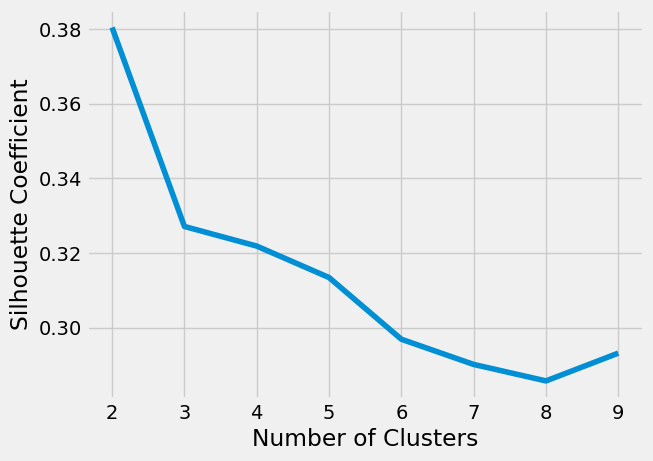

The SS of 0.380 gives the best k at k = 2


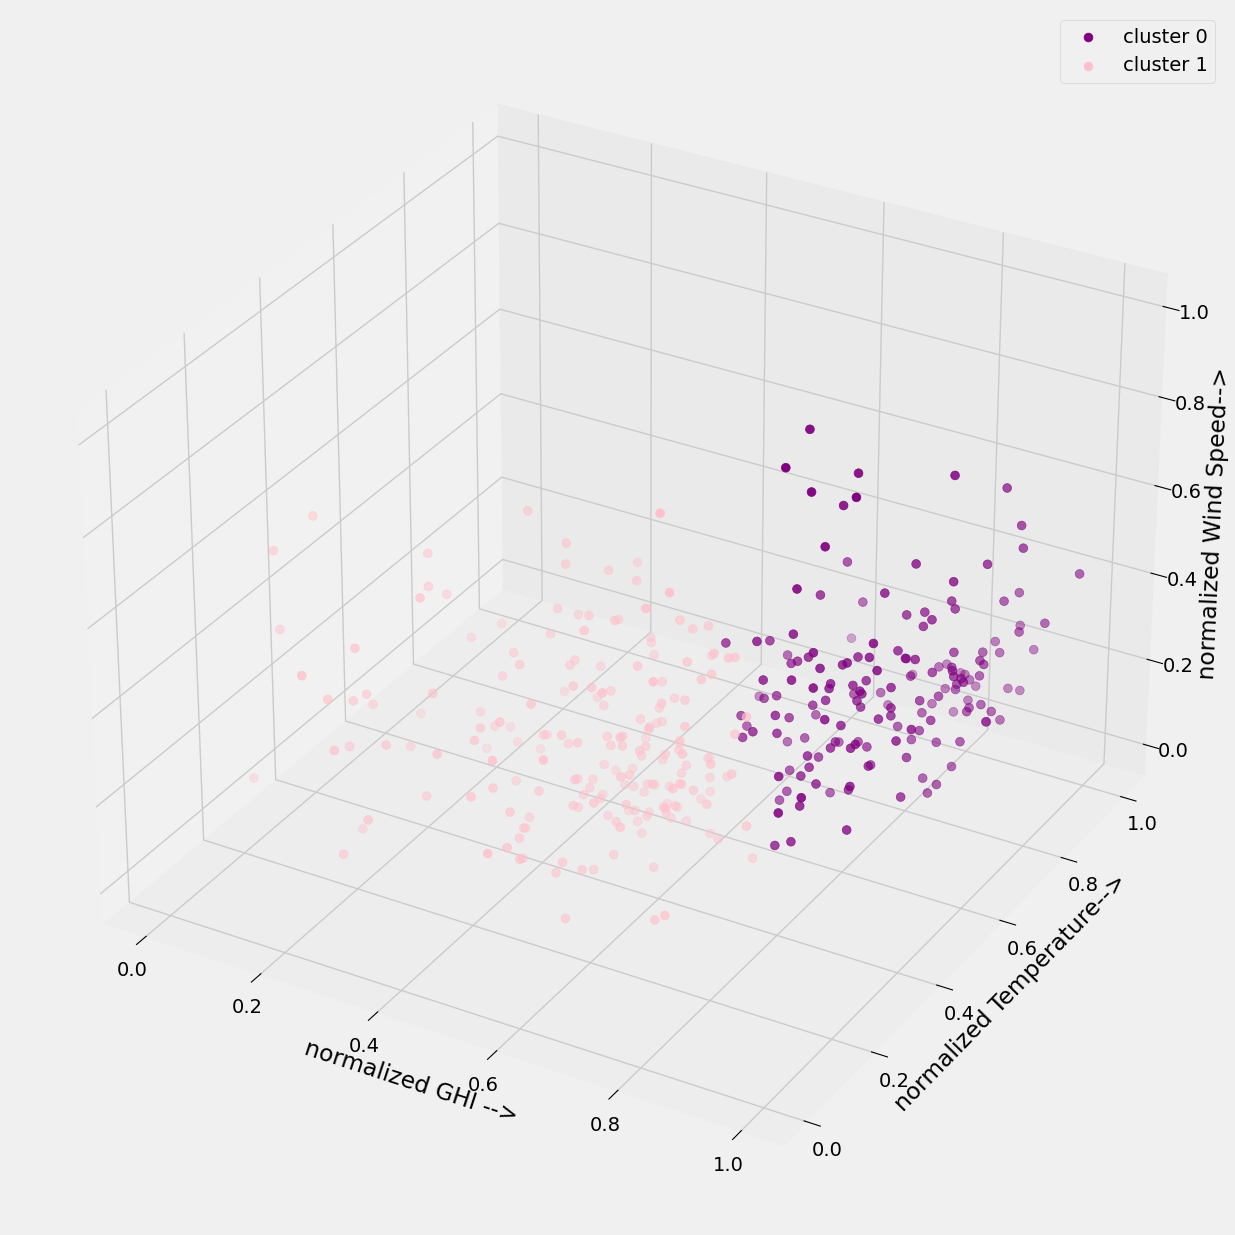

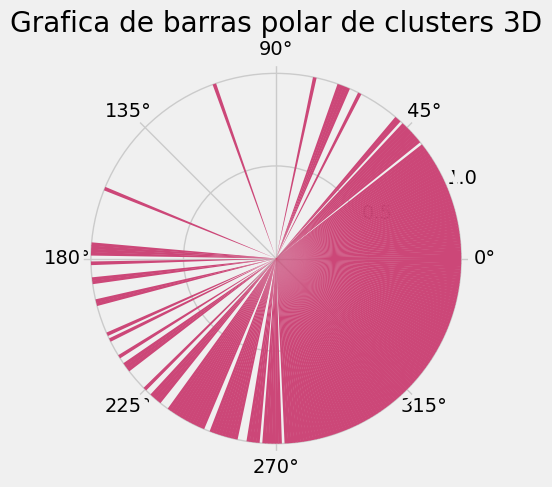

Cluster 0 va de 503.269 a 724.667 W/m^2 ,
de 19.187 a 32.523 grados Celsius
y de 2.017 a 9.274 km/hr

Cluster 1 va de 221.619 a 607.826 W/m^2 ,
de 12.352 a 25.200 grados Celsius
y de 1.495 a 9.696 km/hr



In [16]:
#--------Checking for the best k using Silhouette method.
# A list holds the silhouette coefficients for each k

X = X_GHI_Year.loc[:,['GHI_norm','T_norm','V_norm']]
X = X.to_numpy()

silhouette_coefficients = []

for k in range(2,10): 
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42) 
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)
 
#plotting the different SS.
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#Analyzing the graph
def max_ss(list):
    for i, item in enumerate(list):
        if item == max(list):
            return i
    return None

best_k = max_ss(silhouette_coefficients)+2 #Will be used for the K-mean method later on.
# The '+3' comes from the way we build the method starting in 3.

print(f"The SS of {max(silhouette_coefficients):.3f} gives the best k at k = {best_k}") 


#----------Fit K-means Models
#usando https://www.kaggle.com/code/naren3256/kmeans-clustering-and-cluster-visualization-in-3d/notebook

model = KMeans(n_clusters = best_k, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
y_clusters = model.fit_predict(X)
labels = model.labels_

#3D scatterplot using matplotlib
colors = plt.cm.plasma(labels/best_k)
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[y_clusters == 0,0],X[y_clusters == 0,1],X[y_clusters == 0,2], s = 40 , color = 'purple', label = "cluster 0")
ax.scatter(X[y_clusters == 1,0],X[y_clusters == 1,1],X[y_clusters == 1,2], s = 40 , color = 'pink', label = "cluster 1")
#ax.scatter(X[y_clusters == 2,0],X[y_clusters == 2,1],X[y_clusters == 2,2], s = 40 , color = 'green', label = "cluster 2")
#ax.scatter(X[y_clusters == 3,0],X[y_clusters == 3,1],X[y_clusters == 3,2], s = 40 , color = '#D12B60', label = "cluster 3")
#ax.scatter(x[y_clusters == 4,0],x[y_clusters == 4,1],x[y_clusters == 4,2], s = 40 , color = 'purple', label = "cluster 4")
ax.set_xlabel('normalized GHI -->')
ax.set_ylabel('normalized Temperature-->')
ax.set_zlabel('normalized Wind Speed-->')
ax.legend()
plt.show()

#-----------Agrego los resultados del clustering en la tabla. Yo puedo escoger el destino.
X_GHI_Year.loc[:,'GHI_T_WS_Cluster'] = labels


#https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_bar.html
#------- Compute pie slices
N = 365
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = labels
width = 0.02

ax = plt.subplot(projection='polar')
ax.set_rticks([0.5,1,1.5,2])
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=1)
ax.set_title('Grafica de barras polar de clusters 3D')
plt.show()

#---------Cluster ranges
for i in range(0,best_k):
    Cluster_i = X_GHI_Year.loc[X_GHI_Year['GHI_T_WS_Cluster'] == i, ['Wind Speed', 'GHI', 'Temperature', 'GHI_T_WS_Cluster']]
    print(f"Cluster {i} va de {min(Cluster_i['GHI']):.3f} a {max(Cluster_i['GHI']):.3f} W/m^2 ,")
    print(f"de {min(Cluster_i['Temperature']):.3f} a {max(Cluster_i['Temperature']):.3f} grados Celsius")
    print(f"y de {min(Cluster_i['Wind Speed']):.3f} a {max(Cluster_i['Wind Speed']):.3f} km/hr")
    print()

#### Tabla con fechas

In [17]:
ClustersA = []
ClustersB = []
ClustersC = []
ClustersD = []
ClustersE=[]
LimitesA = []
LimitesB = []
LimitesC = []
LimitesD = []
LimitesE = []

X_GHI_T_WS_Fechas_Clusters = pd.DataFrame()
Inicio = []
Fin = []
N_Cluster = []




for j in range(1, diasaño-1):
    if X_GHI_Year['GHI_T_WS_Cluster'][j] == 0:
        ClustersA.append(int(j))
    elif X_GHI_Year['GHI_T_WS_Cluster'][j] == 1: 
        ClustersB.append(int(j))
    elif X_GHI_Year['GHI_T_WS_Cluster'][j] == 2: 
        ClustersC.append(int(j))
    elif X_GHI_Year['GHI_T_WS_Cluster'][j] == 3: 
        ClustersD.append(int(j))
    elif X_GHI_Year['GHI_T_WS_Cluster'][j] == 4: 
        ClustersE.append(int(j))
    else: 
        None

for k in range(0, len(ClustersA)):
    if ClustersA[k-1] < ClustersA[k] & ClustersA[k] < ClustersA[k-1] + 2: 
        None
    else:
        LimitesA.append(ClustersA[k-1]) , LimitesA.append(ClustersA[k])


for k in range(0, len(ClustersB)):
    if ClustersB[k-1] < ClustersB[k] & ClustersB[k] < ClustersB[k-1] + 2: 
        None
    else:
        LimitesB.append(ClustersB[k-1]) , LimitesB.append(ClustersB[k])

for k in range(0, len(ClustersC)):
    if ClustersC[k-1] < ClustersC[k] & ClustersC[k] < ClustersC[k-1] + 2: 
        None
    else:
        LimitesC.append(ClustersC[k-1]) , LimitesC.append(ClustersC[k])

for k in range(0, len(ClustersD)):
    if ClustersD[k-1] < ClustersD[k] & ClustersD[k] < ClustersD[k-1] + 2: 
        None
    else:
        LimitesD.append(ClustersD[k-1]) , LimitesD.append(ClustersD[k])

for k in range(0, len(ClustersE)):
    if ClustersE[k-1] < ClustersE[k] & ClustersE[k] < ClustersE[k-1] + 2: 
        None
    else:
        LimitesE.append(ClustersE[k-1]) , LimitesE.append(ClustersE[k])


Limites = LimitesA + LimitesB + LimitesC + LimitesD + LimitesE
Limites.sort()

#print(LimitesA)    
#print(LimitesB)
#print(LimitesC)
#print(LimitesD)
#print(LimitesE)
#print(Limites)
#len(Limites)

for i in range(0,len(Limites)):
    if i == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    elif i % 2 == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    else: 
        Fin.append(X_GHI_Year['Date'][Limites[i]]) ,
        N_Cluster.append(X_GHI_Year['GHI_T_WS_Cluster'][Limites[i]])


#len(N_Cluster)
#len(Inicio)
#len(Fin)

X_GHI_T_WS_Fechas_Clusters['Inicia'] = Inicio
X_GHI_T_WS_Fechas_Clusters['Termina'] = Fin
X_GHI_T_WS_Fechas_Clusters['No. de Cluster'] = N_Cluster  

X_GHI_T_WS_Fechas_Clusters

Inicia     Termina  No. de Cluster
0    1/1/1998    8/2/1998               1
1    9/2/1998    9/2/1998               0
2   10/2/1998   17/2/1998               1
3   18/2/1998   18/2/1998               0
4   19/2/1998   20/2/1998               1
5   21/2/1998    5/3/1998               0
6    6/3/1998    6/3/1998               1
7    7/3/1998    9/3/1998               0
8   10/3/1998   13/3/1998               1
9   14/3/1998   20/3/1998               0
10  21/3/1998   21/3/1998               1
11  22/3/1998   21/4/1998               0
12  22/4/1998   22/4/1998               1
13  23/4/1998    9/6/1998               0
14  10/6/1998   10/6/1998               1
15  11/6/1998   27/6/1998               0
16  28/6/1998    1/7/1998               1
17   2/7/1998    3/7/1998               0
18   4/7/1998    4/7/1998               1
19   5/7/1998    8/7/1998               0
20   9/7/1998   10/7/1998               1
21  11/7/1998   15/7/1998               0
22  16/7/1998   17/7/1998               1
23  18/7/1998   26/7/1998               0
24  27/7/1998   27/7/1998               1
25  28/7/1998   28/7/1998               0
26  29/7/1998   29/7/1998               1
27  30/7/1998    3/8/1998               0
28   4/8/1998    4/8/1998               1
29   5/8/1998    6/8/1998               0
30   7/8/1998    9/8/1998               1
31  10/8/1998   16/8/1998               0
32  17/8/1998   17/8/1998               1
33  18/8/1998   19/8/1998               0
34  20/8/1998   23/8/1998               1
35  24/8/1998   26/8/1998               0
36  27/8/1998    8/9/1998               1
37   9/9/1998   10/9/1998               0
38  11/9/1998   19/9/1998               1
39  20/9/1998   22/9/1998               0
40  23/9/1998   26/9/1998               1
41  27/9/1998   27/9/1998               0
42  28/9/1998   3/10/1998               1
43  4/10/1998   4/10/1998               0
44  5/10/1998  31/12/1998               1

### Otra manera de graficar en 3D usando plotly

In [18]:
Scene = dict(xaxis = dict(title  = 'N. GHI -->'),yaxis = dict(title  = 'N. Temperature--->'),zaxis = dict(title  = 'N. Wind Speed-->'))

trace = go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2], mode='markers',marker=dict(color =colors, size= 10, line=dict(color= 'black',width = 10)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

# Cluster Energías

## 1D

### ENERGÍAS EÓLICAS

#### Horas de Sol

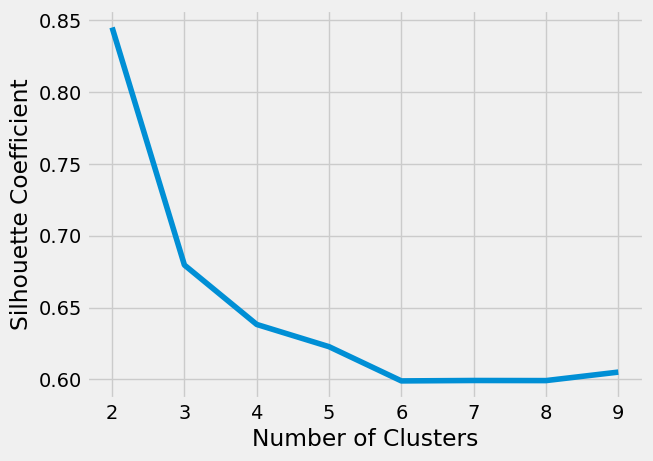

The SS of 0.845 gives the best k at k = 2


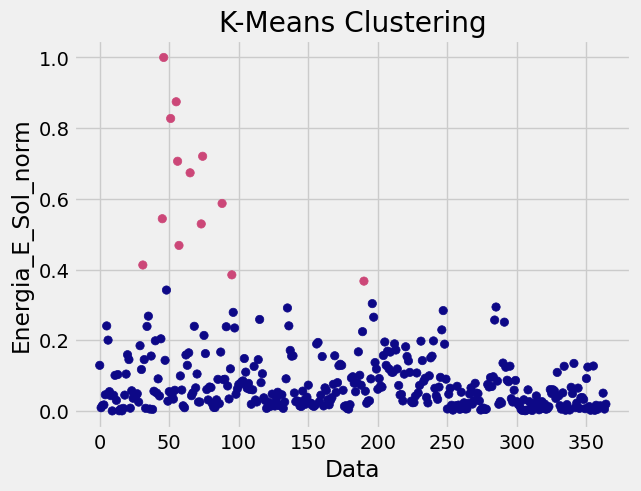

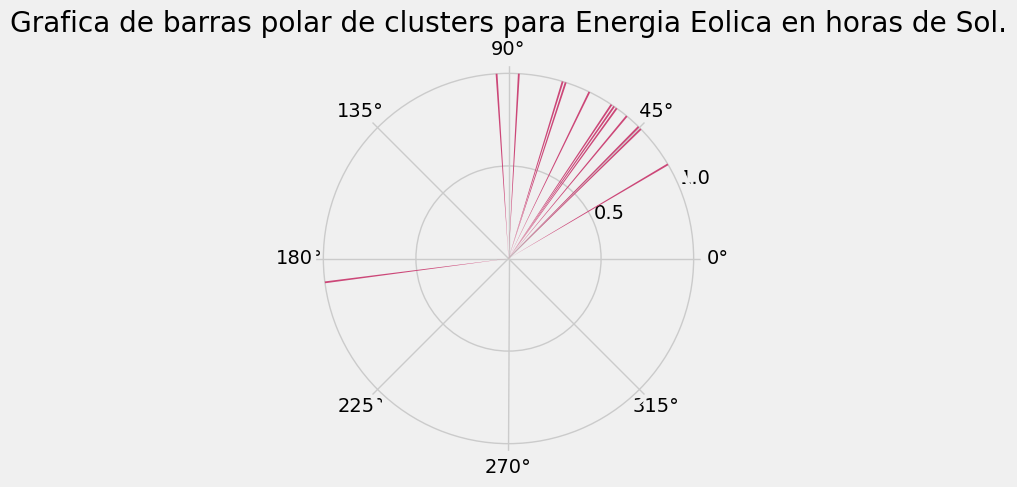

Cluster 0 va de 0.034 a 3.229 W/m^2
Cluster 1 va de 3.465 a 9.377 W/m^2


In [19]:
#--------Checking for the best k using Silhouette method.
# A list holds the silhouette coefficients for each k
X = X_GHI_Year['Energia_E_Sol_norm'].to_numpy()
X = X.reshape(-1,1)

silhouette_coefficients = []

for k in range(2,10): 
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42) 
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)
 
#plotting the different SS.
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#Analyzing the graph
def max_ss(list):
    for i, item in enumerate(list):
        if item == max(list):
            return i
    return None

best_k = max_ss(silhouette_coefficients)+2 #Will be used for the K-mean method later on.
# The '+3' comes from the way we build the method starting in 3.

print(f"The SS of {max(silhouette_coefficients):.3f} gives the best k at k = {best_k}") 

#-----------Fit K-means Model
# Create a k-means instance with k clusters.
kmeans = KMeans(n_clusters=best_k, n_init=10, max_iter=300)
kmeans.fit(X)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_


#----------Visualize Clusters

# Scatter plot of data points
#It changes to this expression using x points as indexes and y points as the real values X
colors = plt.cm.plasma(labels / best_k)
plt.scatter([i for i in range(len(X))], X, color=colors) #FOR 1D CLUSTERING ONLY

# Plot cluster centers
#plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=50, label='Cluster Centers')
#I dont know how to plot centers in a 1D clustering

plt.xlabel('Data')  #Change accordingly
plt.ylabel('Energia_E_Sol_norm')  #Change accordingly
plt.title('K-Means Clustering')
plt.show()


#-----------Agrego los resultados del clustering en la tabla. Yo puedo escoger el destino.
X_GHI_Year.loc[:,'Energia_E_Sol_Cluster'] = labels


#https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_bar.html
#------- Compute pie slices
N = 365
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = labels
width = 0.01

ax = plt.subplot(projection='polar')
ax.set_rticks([0.5, 1, 1.5, 2])
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=1)
ax.set_title('Grafica de barras polar de clusters para Energia Eolica en horas de Sol.')
plt.show()

#---------Cluster ranges
for i in range(0,best_k):
    Cluster_i = X_GHI_Year.loc[X_GHI_Year['Energia_E_Sol_Cluster'] == i, ['Energia_E_Sol', 'Energia_E_Sol_Cluster']]
    print(f"Cluster {i} va de {min(Cluster_i['Energia_E_Sol']):.3f} a {max(Cluster_i['Energia_E_Sol']):.3f} W/m^2")
#Las unidades cambian a w cuando se toma un valor real de A_Rotor.

#### Tabla con fechas

In [20]:
ClustersA = []
ClustersB = []
ClustersC = []
ClustersD = []
ClustersE = []
LimitesA = []
LimitesB = []
LimitesC = []
LimitesD = []
LimitesE = []

X_Energia_E_Sol_Fechas_Clusters = pd.DataFrame()
Inicio = []
Fin = []
N_Cluster = []




for j in range(1, diasaño-1):
    if X_GHI_Year['Energia_E_Sol_Cluster'][j] == 0:
        ClustersA.append(int(j))
    elif X_GHI_Year['Energia_E_Sol_Cluster'][j] == 1: 
        ClustersB.append(int(j))
    elif X_GHI_Year['Energia_E_Sol_Cluster'][j] == 2: 
        ClustersC.append(int(j))
    elif X_GHI_Year['Energia_E_Sol_Cluster'][j] == 3: 
        ClustersD.append(int(j))
    elif X_GHI_Year['Energia_E_Sol_Cluster'][j] == 4: 
        ClustersE.append(int(j))
    else: 
        None

for k in range(0, len(ClustersA)):
    if ClustersA[k-1] < ClustersA[k] & ClustersA[k] < ClustersA[k-1] + 2: 
        None
    else:
        LimitesA.append(ClustersA[k-1]) , LimitesA.append(ClustersA[k])


for k in range(0, len(ClustersB)):
    if ClustersB[k-1] < ClustersB[k] & ClustersB[k] < ClustersB[k-1] + 2: 
        None
    else:
        LimitesB.append(ClustersB[k-1]) , LimitesB.append(ClustersB[k])

for k in range(0, len(ClustersC)):
    if ClustersC[k-1] < ClustersC[k] & ClustersC[k] < ClustersC[k-1] + 2: 
        None
    else:
        LimitesC.append(ClustersC[k-1]) , LimitesC.append(ClustersC[k])

for k in range(0, len(ClustersD)):
    if ClustersD[k-1] < ClustersD[k] & ClustersD[k] < ClustersD[k-1] + 2: 
        None
    else:
        LimitesD.append(ClustersD[k-1]) , LimitesD.append(ClustersD[k])

for k in range(0, len(ClustersE)):
    if ClustersE[k-1] < ClustersE[k] & ClustersE[k] < ClustersE[k-1] + 2: 
        None
    else:
        LimitesE.append(ClustersE[k-1]) , LimitesE.append(ClustersE[k])


Limites = LimitesA + LimitesB + LimitesC + LimitesD + LimitesE
Limites.sort()

#print(LimitesA)    
#print(LimitesB)
#print(LimitesC)
#print(LimitesD)
#print(LimitesE)
#print(Limites)
#len(Limites)

for i in range(0,len(Limites)):
    if i == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    elif i % 2 == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    else: 
        Fin.append(X_GHI_Year['Date'][Limites[i]]) ,
        N_Cluster.append(X_GHI_Year['Energia_E_Sol_Cluster'][Limites[i]])


#len(N_Cluster)
#len(Inicio)
#len(Fin)

X_Energia_E_Sol_Fechas_Clusters['Inicia'] = Inicio
X_Energia_E_Sol_Fechas_Clusters['Termina'] = Fin
X_Energia_E_Sol_Fechas_Clusters['No. de Cluster'] = N_Cluster  

X_Energia_E_Sol_Fechas_Clusters

Inicia     Termina  No. de Cluster
0    1/1/1998   31/1/1998               0
1    1/2/1998    1/2/1998               1
2    2/2/1998   14/2/1998               0
3   15/2/1998   16/2/1998               1
4   17/2/1998   20/2/1998               0
5   21/2/1998   21/2/1998               1
6   22/2/1998   24/2/1998               0
7   25/2/1998   27/2/1998               1
8   28/2/1998    6/3/1998               0
9    7/3/1998    7/3/1998               1
10   8/3/1998   14/3/1998               0
11  15/3/1998   16/3/1998               1
12  17/3/1998   29/3/1998               0
13  30/3/1998   30/3/1998               1
14  31/3/1998    5/4/1998               0
15   6/4/1998    6/4/1998               1
16   7/4/1998    9/7/1998               0
17  10/7/1998   10/7/1998               1
18  11/7/1998  31/12/1998               0

#### Dia completo

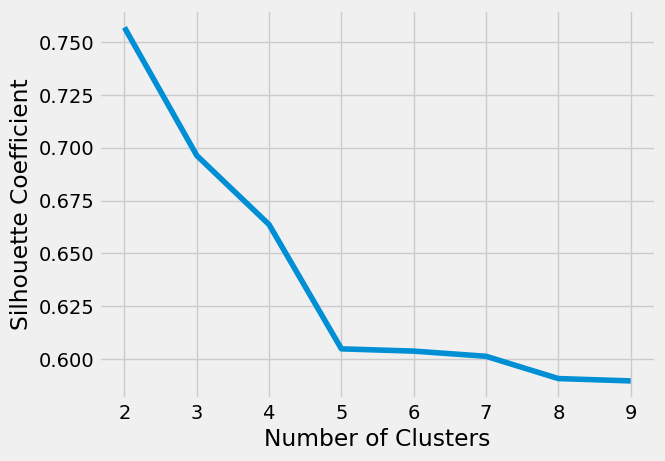

The SS of 0.757 gives the best k at k = 2


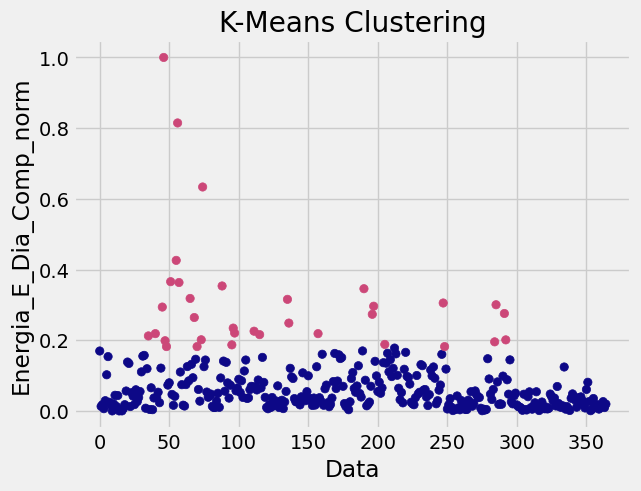

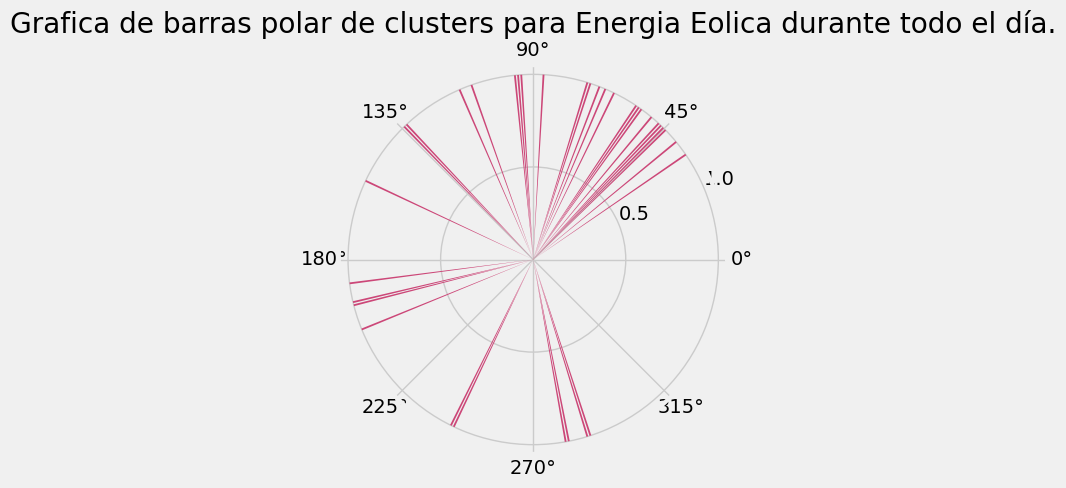

Cluster 0 va de 0.022 a 0.995 W/m^2
Cluster 1 va de 1.018 a 5.493 W/m^2


In [21]:
#--------Checking for the best k using Silhouette method.
# A list holds the silhouette coefficients for each k
X = X_GHI_Year['Energia_E_Dia_Comp_norm'].to_numpy()
X = X.reshape(-1,1)

silhouette_coefficients = []

for k in range(2,10): 
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42) 
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)
 
#plotting the different SS.
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#Analyzing the graph
def max_ss(list):
    for i, item in enumerate(list):
        if item == max(list):
            return i
    return None

best_k = max_ss(silhouette_coefficients)+2 #Will be used for the K-mean method later on.
# The '+3' comes from the way we build the method starting in 3.

print(f"The SS of {max(silhouette_coefficients):.3f} gives the best k at k = {best_k}") 

#-----------Fit K-means Model
# Create a k-means instance with k clusters.
kmeans = KMeans(n_clusters=best_k, n_init=10, max_iter=300)
kmeans.fit(X)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_


#----------Visualize Clusters

# Scatter plot of data points
#It changes to this expression using x points as indexes and y points as the real values X
colors = plt.cm.plasma(labels / best_k)
plt.scatter([i for i in range(len(X))], X, color=colors) #FOR 1D CLUSTERING ONLY

# Plot cluster centers
#plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=50, label='Cluster Centers')
#I dont know how to plot centers in a 1D clustering

plt.xlabel('Data')  #Change accordingly
plt.ylabel('Energia_E_Dia_Comp_norm')  #Change accordingly
plt.title('K-Means Clustering')
plt.show()


#-----------Agrego los resultados del clustering en la tabla. Yo puedo escoger el destino.
X_GHI_Year.loc[:,'Energia_E_Dia_Comp_Cluster'] = labels


#https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_bar.html
#------- Compute pie slices
N = 365
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = labels
width = 0.01

ax = plt.subplot(projection='polar')
ax.set_rticks([0.5, 1, 1.5, 2])
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=1)
ax.set_title('Grafica de barras polar de clusters para Energia Eolica durante todo el día.')
plt.show()

#---------Cluster ranges
for i in range(0,best_k):
    Cluster_i = X_GHI_Year.loc[X_GHI_Year['Energia_E_Dia_Comp_Cluster'] == i, ['Energia_E_Dia_Comp', 'Energia_E_Dia_Comp_Cluster']]
    print(f"Cluster {i} va de {min(Cluster_i['Energia_E_Dia_Comp']):.3f} a {max(Cluster_i['Energia_E_Dia_Comp']):.3f} W/m^2")
#Las unidades cambian a w cuando se toma un valor real de A_Rotor.

#### Tabla con fechas

In [22]:
ClustersA = []
ClustersB = []
ClustersC = []
ClustersD = []
ClustersE=[]
LimitesA = []
LimitesB = []
LimitesC = []
LimitesD = []
LimitesE = []

X_Energia_E_Dia_Comp_Fechas_Clusters = pd.DataFrame()
Inicio = []
Fin = []
N_Cluster = []




for j in range(1, diasaño-1):
    if X_GHI_Year['Energia_E_Dia_Comp_Cluster'][j] == 0:
        ClustersA.append(int(j))
    elif X_GHI_Year['Energia_E_Dia_Comp_Cluster'][j] == 1: 
        ClustersB.append(int(j))
    elif X_GHI_Year['Energia_E_Dia_Comp_Cluster'][j] == 2: 
        ClustersC.append(int(j))
    elif X_GHI_Year['Energia_E_Dia_Comp_Cluster'][j] == 3: 
        ClustersD.append(int(j))
    elif X_GHI_Year['Energia_E_Dia_Comp_Cluster'][j] == 4: 
        ClustersE.append(int(j))
    else: 
        None

for k in range(0, len(ClustersA)):
    if ClustersA[k-1] < ClustersA[k] & ClustersA[k] < ClustersA[k-1] + 2: 
        None
    else:
        LimitesA.append(ClustersA[k-1]) , LimitesA.append(ClustersA[k])


for k in range(0, len(ClustersB)):
    if ClustersB[k-1] < ClustersB[k] & ClustersB[k] < ClustersB[k-1] + 2: 
        None
    else:
        LimitesB.append(ClustersB[k-1]) , LimitesB.append(ClustersB[k])

for k in range(0, len(ClustersC)):
    if ClustersC[k-1] < ClustersC[k] & ClustersC[k] < ClustersC[k-1] + 2: 
        None
    else:
        LimitesC.append(ClustersC[k-1]) , LimitesC.append(ClustersC[k])

for k in range(0, len(ClustersD)):
    if ClustersD[k-1] < ClustersD[k] & ClustersD[k] < ClustersD[k-1] + 2: 
        None
    else:
        LimitesD.append(ClustersD[k-1]) , LimitesD.append(ClustersD[k])

for k in range(0, len(ClustersE)):
    if ClustersE[k-1] < ClustersE[k] & ClustersE[k] < ClustersE[k-1] + 2: 
        None
    else:
        LimitesE.append(ClustersE[k-1]) , LimitesE.append(ClustersE[k])


Limites = LimitesA + LimitesB + LimitesC + LimitesD + LimitesE
Limites.sort()

#print(LimitesA)    
#print(LimitesB)
#print(LimitesC)
#print(LimitesD)
#print(LimitesE)
#print(Limites)
#len(Limites)

for i in range(0,len(Limites)):
    if i == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    elif i % 2 == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    else: 
        Fin.append(X_GHI_Year['Date'][Limites[i]]) ,
        N_Cluster.append(X_GHI_Year['Energia_E_Dia_Comp_Cluster'][Limites[i]])


#len(N_Cluster)
#len(Inicio)
#len(Fin)

X_Energia_E_Dia_Comp_Fechas_Clusters['Inicia'] = Inicio
X_Energia_E_Dia_Comp_Fechas_Clusters['Termina'] = Fin
X_Energia_E_Dia_Comp_Fechas_Clusters['No. de Cluster'] = N_Cluster  

X_Energia_E_Dia_Comp_Fechas_Clusters

Inicia     Termina  No. de Cluster
0     1/1/1998    4/2/1998               0
1     5/2/1998    5/2/1998               1
2     6/2/1998    9/2/1998               0
3    10/2/1998   10/2/1998               1
4    11/2/1998   14/2/1998               0
5    15/2/1998   18/2/1998               1
6    19/2/1998   20/2/1998               0
7    21/2/1998   21/2/1998               1
8    22/2/1998   24/2/1998               0
9    25/2/1998   27/2/1998               1
10   28/2/1998    6/3/1998               0
11    7/3/1998    7/3/1998               1
12    8/3/1998    9/3/1998               0
13   10/3/1998   10/3/1998               1
14   11/3/1998   11/3/1998               0
15   12/3/1998   12/3/1998               1
16   13/3/1998   14/3/1998               0
17   15/3/1998   16/3/1998               1
18   17/3/1998   29/3/1998               0
19   30/3/1998   30/3/1998               1
20   31/3/1998    5/4/1998               0
21    6/4/1998    8/4/1998               1
22    9/4/1998   21/4/1998               0
23   22/4/1998   22/4/1998               1
24   23/4/1998   25/4/1998               0
25   26/4/1998   26/4/1998               1
26   27/4/1998   15/5/1998               0
27   16/5/1998   17/5/1998               1
28   18/5/1998    6/6/1998               0
29    7/6/1998    7/6/1998               1
30    8/6/1998    9/7/1998               0
31   10/7/1998   10/7/1998               1
32   11/7/1998   15/7/1998               0
33   16/7/1998   17/7/1998               1
34   18/7/1998   24/7/1998               0
35   25/7/1998   25/7/1998               1
36   26/7/1998    4/9/1998               0
37    5/9/1998    6/9/1998               1
38    7/9/1998  11/10/1998               0
39  12/10/1998  13/10/1998               1
40  14/10/1998  18/10/1998               0
41  19/10/1998  20/10/1998               1
42  21/10/1998  31/12/1998               0

### ENERGÍA SOLAR

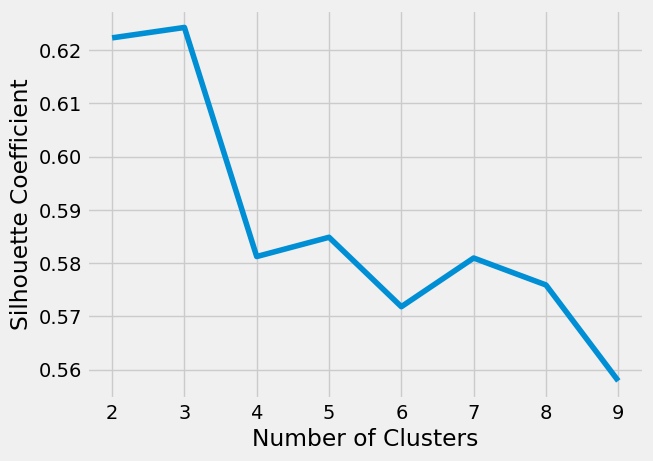

The SS of 0.624 gives the best k at k = 3


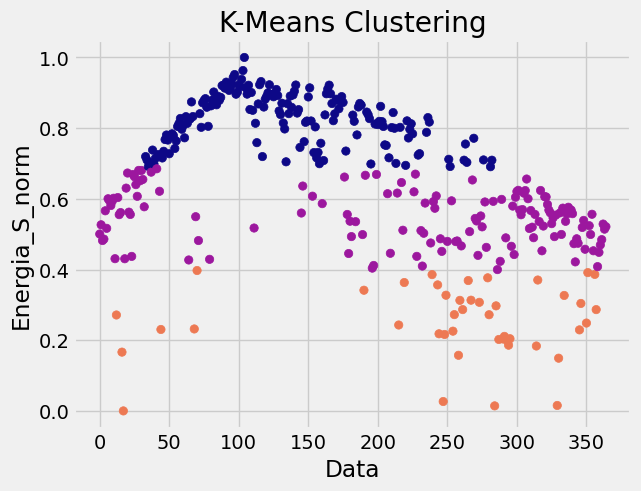

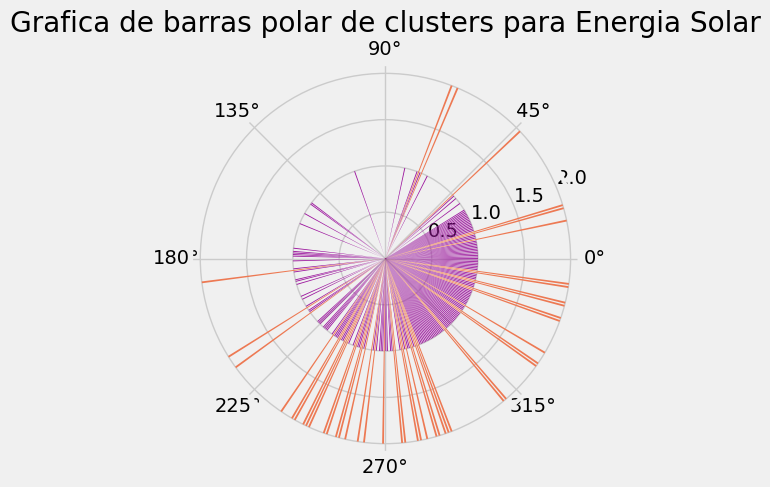

Cluster 0 va de 56.917 a 72.467 W/m^2 por hora = Volts por hora
Cluster 1 va de 42.274 a 56.622 W/m^2 por hora = Volts por hora
Cluster 2 va de 22.162 a 42.143 W/m^2 por hora = Volts por hora


In [23]:
#--------Checking for the best k using Silhouette method.
# A list holds the silhouette coefficients for each k
X = X_GHI_Year['Energia_S_norm'].to_numpy()
X = X.reshape(-1,1)

silhouette_coefficients = []

for k in range(2,10): 
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42) 
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)
 
#plotting the different SS.
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#Analyzing the graph
def max_ss(list):
    for i, item in enumerate(list):
        if item == max(list):
            return i
    return None

best_k = max_ss(silhouette_coefficients)+2 #Will be used for the K-mean method later on.
# The '+3' comes from the way we build the method starting in 3.

print(f"The SS of {max(silhouette_coefficients):.3f} gives the best k at k = {best_k}") 

#-----------Fit K-means Model
# Create a k-means instance with k clusters.
kmeans = KMeans(n_clusters=best_k, n_init=10, max_iter=300)
kmeans.fit(X)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_


#----------Visualize Clusters

# Scatter plot of data points
#It changes to this expression using x points as indexes and y points as the real values X
colors = plt.cm.plasma(labels / best_k)
plt.scatter([i for i in range(len(X))], X, color=colors) #FOR 1D CLUSTERING ONLY

# Plot cluster centers
#plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=50, label='Cluster Centers')
#I dont know how to plot centers in a 1D clustering

plt.xlabel('Data')  #Change accordingly
plt.ylabel('Energia_S_norm')  #Change accordingly
plt.title('K-Means Clustering')
plt.show()


#-----------Agrego los resultados del clustering en la tabla. Yo puedo escoger el destino.
X_GHI_Year.loc[:,'Energia_S_Cluster'] = labels


#https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_bar.html
#------- Compute pie slices
N = 365
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = labels
width = 0.01

ax = plt.subplot(projection='polar')
ax.set_rticks([0.5, 1, 1.5, 2])
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=1)
ax.set_title('Grafica de barras polar de clusters para Energia Solar')
plt.show()

#---------Cluster ranges
for i in range(0,best_k):
    Cluster_i = X_GHI_Year.loc[X_GHI_Year['Energia_S_Cluster'] == i, ['Energia_S', 'Energia_S_Cluster']]
    print(f"Cluster {i} va de {min(Cluster_i['Energia_S']):.3f} a {max(Cluster_i['Energia_S']):.3f} W/m^2 por hora = Volts por hora")
#Las unidades cambian a w cuando se toma un valor real de A_Rotor.

#### Tabla con fechas

In [24]:
ClustersA = []
ClustersB = []
ClustersC = []
ClustersD = []
ClustersE=[]
LimitesA = []
LimitesB = []
LimitesC = []
LimitesD = []
LimitesE = []

X_Energia_S_Fechas_Clusters = pd.DataFrame()
Inicio = []
Fin = []
N_Cluster = []




for j in range(1, diasaño-1):
    if X_GHI_Year['Energia_S_Cluster'][j] == 0:
        ClustersA.append(int(j))
    elif X_GHI_Year['Energia_S_Cluster'][j] == 1: 
        ClustersB.append(int(j))
    elif X_GHI_Year['Energia_S_Cluster'][j] == 2: 
        ClustersC.append(int(j))
    elif X_GHI_Year['Energia_S_Cluster'][j] == 3: 
        ClustersD.append(int(j))
    elif X_GHI_Year['Energia_S_Cluster'][j] == 4: 
        ClustersE.append(int(j))
    else: 
        None

for k in range(0, len(ClustersA)):
    if ClustersA[k-1] < ClustersA[k] & ClustersA[k] < ClustersA[k-1] + 2: 
        None
    else:
        LimitesA.append(ClustersA[k-1]) , LimitesA.append(ClustersA[k])


for k in range(0, len(ClustersB)):
    if ClustersB[k-1] < ClustersB[k] & ClustersB[k] < ClustersB[k-1] + 2: 
        None
    else:
        LimitesB.append(ClustersB[k-1]) , LimitesB.append(ClustersB[k])

for k in range(0, len(ClustersC)):
    if ClustersC[k-1] < ClustersC[k] & ClustersC[k] < ClustersC[k-1] + 2: 
        None
    else:
        LimitesC.append(ClustersC[k-1]) , LimitesC.append(ClustersC[k])

for k in range(0, len(ClustersD)):
    if ClustersD[k-1] < ClustersD[k] & ClustersD[k] < ClustersD[k-1] + 2: 
        None
    else:
        LimitesD.append(ClustersD[k-1]) , LimitesD.append(ClustersD[k])

for k in range(0, len(ClustersE)):
    if ClustersE[k-1] < ClustersE[k] & ClustersE[k] < ClustersE[k-1] + 2: 
        None
    else:
        LimitesE.append(ClustersE[k-1]) , LimitesE.append(ClustersE[k])


Limites = LimitesA + LimitesB + LimitesC + LimitesD + LimitesE
Limites.sort()

#print(LimitesA)    
#print(LimitesB)
#print(LimitesC)
#print(LimitesD)
#print(LimitesE)
#print(Limites)
#len(Limites)

for i in range(0,len(Limites)):
    if i == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    elif i % 2 == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    else: 
        Fin.append(X_GHI_Year['Date'][Limites[i]]) ,
        N_Cluster.append(X_GHI_Year['Energia_S_Cluster'][Limites[i]])


#len(N_Cluster)
#len(Inicio)
#len(Fin)

X_Energia_S_Fechas_Clusters['Inicia'] = Inicio
X_Energia_S_Fechas_Clusters['Termina'] = Fin
X_Energia_S_Fechas_Clusters['No. de Cluster'] = N_Cluster  

X_Energia_S_Fechas_Clusters

Inicia     Termina  No. de Cluster
0      1/1/1998   12/1/1998               1
1     13/1/1998   13/1/1998               2
2     14/1/1998   16/1/1998               1
3     17/1/1998   18/1/1998               2
4     19/1/1998    2/2/1998               1
..          ...         ...             ...
101  14/12/1998  16/12/1998               1
102  17/12/1998  18/12/1998               2
103  19/12/1998  22/12/1998               1
104  23/12/1998  24/12/1998               2
105  25/12/1998  31/12/1998               1

[106 rows x 3 columns]

## 2D

### Tomando horas de Sol para Energía Eólica

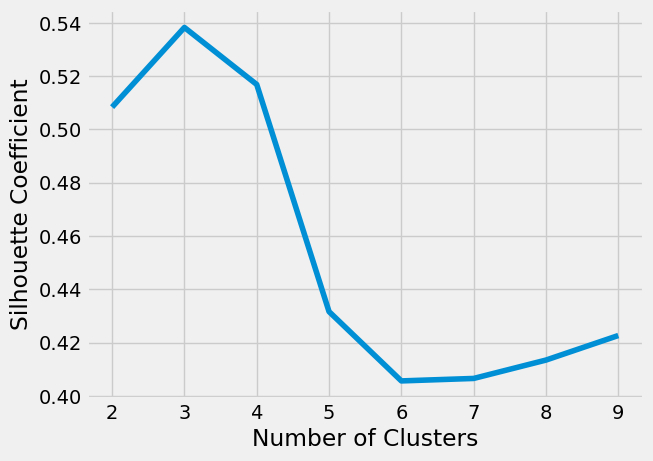

The SS of 0.538 gives the best k at k = 3


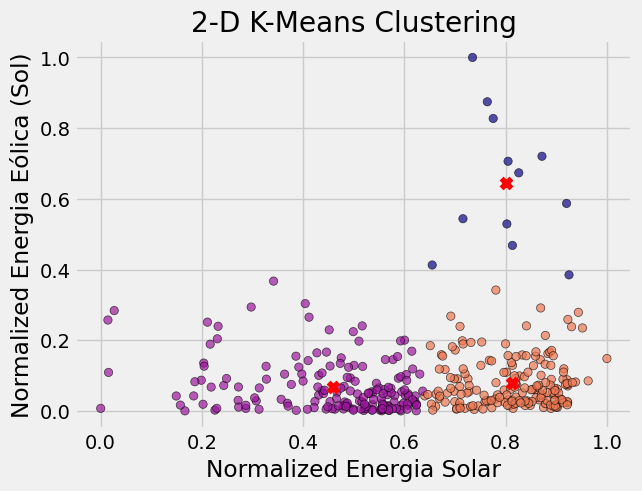

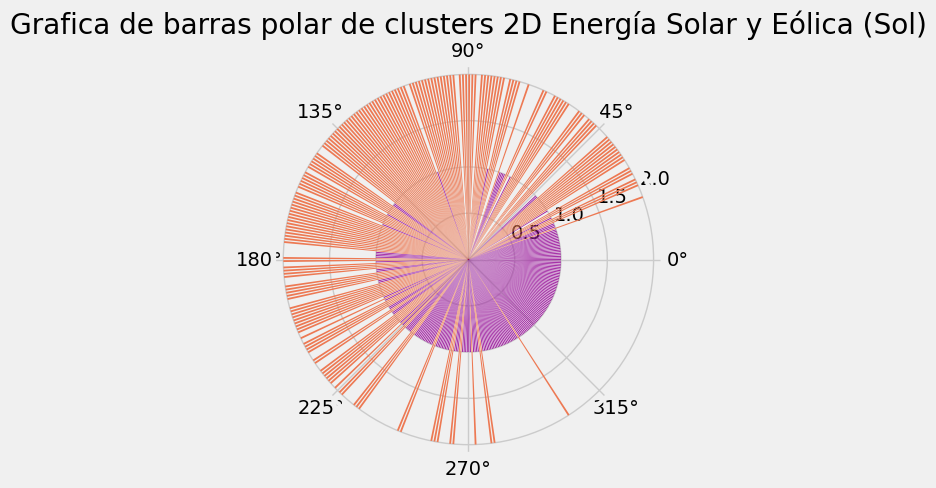

Cluster 0 va de 3.631 a 9.377 W/m^2
y de 55.105 a 68.700 W/m^2 por hora

Cluster 1 va de 0.034 a 3.465 W/m^2
y de 22.162 a 54.165 W/m^2 por hora

Cluster 2 va de 0.056 a 3.229 W/m^2
y de 54.367 a 72.467 W/m^2 por hora



In [25]:
#--------Checking for the best k using Silhouette method.
# A list holds the silhouette coefficients for each k
X = X_GHI_Year[['Energia_S_norm','Energia_E_Sol_norm']]
X = X.to_numpy()

silhouette_coefficients = []

for k in range(2,10): 
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42) 
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)
 
#plotting the different SS.
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#Analyzing the graph
def max_ss(list):
    for i, item in enumerate(list):
        if item == max(list):
            return i
    return None

best_k = max_ss(silhouette_coefficients)+2 #Will be used for the K-mean method later on.
# The '+3' comes from the way we build the method starting in 3.

print(f"The SS of {max(silhouette_coefficients):.3f} gives the best k at k = {best_k}") 


#-----------Fit K-means Model
# Create a k-means instance with k clusters.
kmeans = KMeans(n_clusters=best_k, n_init=10, max_iter=300)
kmeans.fit(X)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_


#----------Visualize Clusters
# Scatter plot of data points

#It changes to this expression using x points as indexes and y points as the real values X
colors = plt.cm.plasma(labels / best_k)
plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.7, edgecolors='k')

#---------Plot cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=50, label='Cluster Centers')
#I dont know hot to plot centers in a 1D clustering

plt.xlabel('Normalized Energia Solar')  #Change accordingly
plt.ylabel('Normalized Energia Eólica (Sol)')  #Change accordingly
plt.title('2-D K-Means Clustering') 
plt.show()


#-----------Agrego los resultados del clustering en la tabla. Yo puedo escoger el destino.
X_GHI_Year.loc[:,'Energia_S_E_Sol_Cluster'] = labels


#https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_bar.html
#------- Compute pie slices
N = 365
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = labels
width = 0.01

ax = plt.subplot(projection='polar')
ax.set_rticks([0.5, 1, 1.5, 2, 2.5, 3])
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=1)
ax.set_title('Grafica de barras polar de clusters 2D Energía Solar y Eólica (Sol)')
plt.show()

#---------Cluster ranges
for i in range(0,best_k):
    Cluster_i = X_GHI_Year.loc[X_GHI_Year['Energia_S_E_Sol_Cluster'] == i, ['Energia_S', 'Energia_E_Sol', 'Energia_S_E_Sol_Cluster']]
    print(f"Cluster {i} va de {min(Cluster_i['Energia_E_Sol']):.3f} a {max(Cluster_i['Energia_E_Sol']):.3f} W/m^2")
    print(f"y de {min(Cluster_i['Energia_S']):.3f} a {max(Cluster_i['Energia_S']):.3f} W/m^2 por hora")
    print()


#### Tabla con fechas

In [26]:
ClustersA = []
ClustersB = []
ClustersC = []
ClustersD = []
ClustersE=[]
LimitesA = []
LimitesB = []
LimitesC = []
LimitesD = []
LimitesE = []

X_Energia_S_E_Sol_Fechas_Clusters = pd.DataFrame()
Inicio = []
Fin = []
N_Cluster = []




for j in range(1, diasaño-1):
    if X_GHI_Year['Energia_S_E_Sol_Cluster'][j] == 0:
        ClustersA.append(int(j))
    elif X_GHI_Year['Energia_S_E_Sol_Cluster'][j] == 1: 
        ClustersB.append(int(j))
    elif X_GHI_Year['Energia_S_E_Sol_Cluster'][j] == 2: 
        ClustersC.append(int(j))
    elif X_GHI_Year['Energia_S_E_Sol_Cluster'][j] == 3: 
        ClustersD.append(int(j))
    elif X_GHI_Year['Energia_S_E_Sol_Cluster'][j] == 4: 
        ClustersE.append(int(j))
    else: 
        None

for k in range(0, len(ClustersA)):
    if ClustersA[k-1] < ClustersA[k] & ClustersA[k] < ClustersA[k-1] + 2: 
        None
    else:
        LimitesA.append(ClustersA[k-1]) , LimitesA.append(ClustersA[k])


for k in range(0, len(ClustersB)):
    if ClustersB[k-1] < ClustersB[k] & ClustersB[k] < ClustersB[k-1] + 2: 
        None
    else:
        LimitesB.append(ClustersB[k-1]) , LimitesB.append(ClustersB[k])

for k in range(0, len(ClustersC)):
    if ClustersC[k-1] < ClustersC[k] & ClustersC[k] < ClustersC[k-1] + 2: 
        None
    else:
        LimitesC.append(ClustersC[k-1]) , LimitesC.append(ClustersC[k])

for k in range(0, len(ClustersD)):
    if ClustersD[k-1] < ClustersD[k] & ClustersD[k] < ClustersD[k-1] + 2: 
        None
    else:
        LimitesD.append(ClustersD[k-1]) , LimitesD.append(ClustersD[k])

for k in range(0, len(ClustersE)):
    if ClustersE[k-1] < ClustersE[k] & ClustersE[k] < ClustersE[k-1] + 2: 
        None
    else:
        LimitesE.append(ClustersE[k-1]) , LimitesE.append(ClustersE[k])


Limites = LimitesA + LimitesB + LimitesC + LimitesD + LimitesE
Limites.sort()

#print(LimitesA)    
#print(LimitesB)
#print(LimitesC)
#print(LimitesD)
#print(LimitesE)
#print(Limites)
#len(Limites)

for i in range(0,len(Limites)):
    if i == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    elif i % 2 == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    else: 
        Fin.append(X_GHI_Year['Date'][Limites[i]]) ,
        N_Cluster.append(X_GHI_Year['Energia_S_E_Sol_Cluster'][Limites[i]])


#len(N_Cluster)
#len(Inicio)
#len(Fin)

X_Energia_S_E_Sol_Fechas_Clusters['Inicia'] = Inicio
X_Energia_S_E_Sol_Fechas_Clusters['Termina'] = Fin
X_Energia_S_E_Sol_Fechas_Clusters['No. de Cluster'] = N_Cluster  

X_Energia_S_E_Sol_Fechas_Clusters

Inicia     Termina  No. de Cluster
0     1/1/1998   20/1/1998               1
1    21/1/1998   21/1/1998               2
2    22/1/1998   24/1/1998               1
3    25/1/1998   27/1/1998               2
4    28/1/1998   28/1/1998               1
..         ...         ...             ...
67   5/10/1998   8/10/1998               1
68   9/10/1998  10/10/1998               2
69  11/10/1998   3/11/1998               1
70   4/11/1998   4/11/1998               2
71   5/11/1998  31/12/1998               1

[72 rows x 3 columns]

### Tomando las 24 horas del día para Energía Eólica

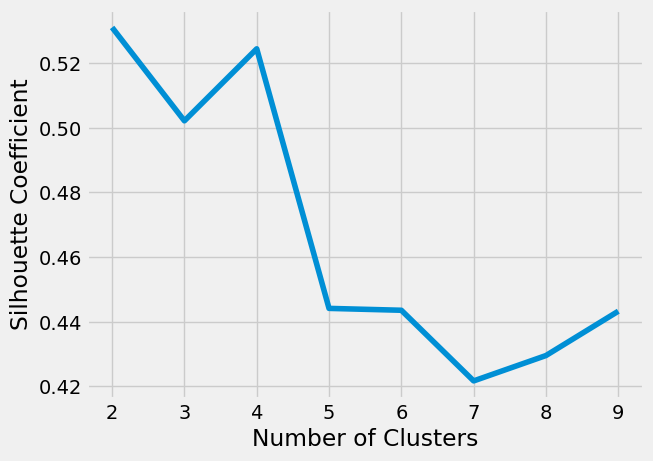

The SS of 0.531 gives the best k at k = 2


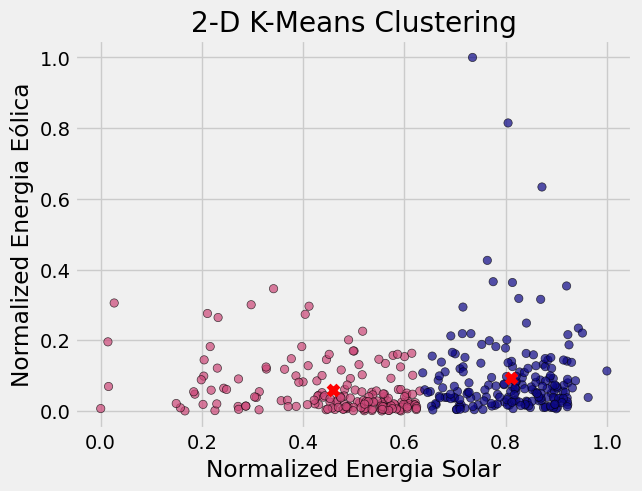

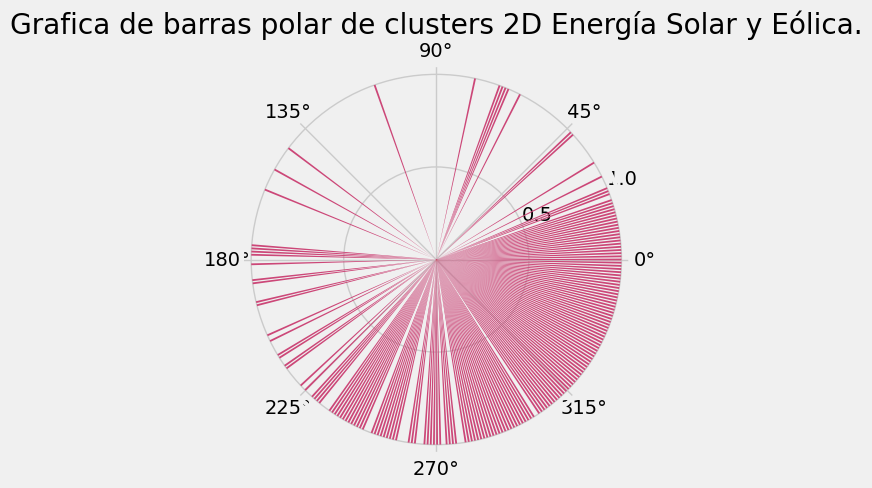

Cluster 0 va de 0.037 a 5.493 W/m^2
y de 54.165 a 72.467 W/m^2 por hora

Cluster 1 va de 0.022 a 1.914 W/m^2
y de 22.162 a 53.871 W/m^2 por hora



In [27]:
#--------Checking for the best k using Silhouette method.
# A list holds the silhouette coefficients for each k
X = X_GHI_Year[['Energia_S_norm','Energia_E_Dia_Comp_norm']]
X = X.to_numpy()

silhouette_coefficients = []

for k in range(2,10): 
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42) 
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)
 
#plotting the different SS.
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#Analyzing the graph
def max_ss(list):
    for i, item in enumerate(list):
        if item == max(list):
            return i
    return None

best_k = max_ss(silhouette_coefficients)+2 #Will be used for the K-mean method later on.
# The '+3' comes from the way we build the method starting in 3.

print(f"The SS of {max(silhouette_coefficients):.3f} gives the best k at k = {best_k}") 


#-----------Fit K-means Model
# Create a k-means instance with k clusters.
kmeans = KMeans(n_clusters=best_k, n_init=10, max_iter=300)
kmeans.fit(X)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_


#----------Visualize Clusters
# Scatter plot of data points

#It changes to this expression using x points as indexes and y points as the real values X
colors = plt.cm.plasma(labels / best_k)
plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.7, edgecolors='k')

#---------Plot cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=50, label='Cluster Centers')
#I dont know hot to plot centers in a 1D clustering

plt.xlabel('Normalized Energia Solar')  #Change accordingly
plt.ylabel('Normalized Energia Eólica')  #Change accordingly
plt.title('2-D K-Means Clustering') 
plt.show()


#-----------Agrego los resultados del clustering en la tabla. Yo puedo escoger el destino.
X_GHI_Year.loc[:,'Energia_S_E_Cluster'] = labels


#https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_bar.html
#------- Compute pie slices
N = 365
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = labels
width = 0.01

ax = plt.subplot(projection='polar')
ax.set_rticks([0.5, 1, 1.5, 2, 2.5, 3])
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=1)
ax.set_title('Grafica de barras polar de clusters 2D Energía Solar y Eólica.')
plt.show()

#---------Cluster ranges
for i in range(0,best_k):
    Cluster_i = X_GHI_Year.loc[X_GHI_Year['Energia_S_E_Cluster'] == i, ['Energia_S', 'Energia_E_Dia_Comp', 'Energia_S_E_Cluster']]
    print(f"Cluster {i} va de {min(Cluster_i['Energia_E_Dia_Comp']):.3f} a {max(Cluster_i['Energia_E_Dia_Comp']):.3f} W/m^2")
    print(f"y de {min(Cluster_i['Energia_S']):.3f} a {max(Cluster_i['Energia_S']):.3f} W/m^2 por hora")
    print()

#### Tabla con fechas

In [28]:
ClustersA = []
ClustersB = []
ClustersC = []
ClustersD = []
ClustersE=[]
LimitesA = []
LimitesB = []
LimitesC = []
LimitesD = []
LimitesE = []

X_Energia_S_E_Fechas_Clusters = pd.DataFrame()
Inicio = []
Fin = []
N_Cluster = []




for j in range(1, diasaño-1):
    if X_GHI_Year['Energia_S_E_Cluster'][j] == 0:
        ClustersA.append(int(j))
    elif X_GHI_Year['Energia_S_E_Cluster'][j] == 1: 
        ClustersB.append(int(j))
    elif X_GHI_Year['Energia_S_E_Cluster'][j] == 2: 
        ClustersC.append(int(j))
    elif X_GHI_Year['Energia_S_E_Cluster'][j] == 3: 
        ClustersD.append(int(j))
    elif X_GHI_Year['Energia_S_E_Cluster'][j] == 4: 
        ClustersE.append(int(j))
    else: 
        None

for k in range(0, len(ClustersA)):
    if ClustersA[k-1] < ClustersA[k] & ClustersA[k] < ClustersA[k-1] + 2: 
        None
    else:
        LimitesA.append(ClustersA[k-1]) , LimitesA.append(ClustersA[k])


for k in range(0, len(ClustersB)):
    if ClustersB[k-1] < ClustersB[k] & ClustersB[k] < ClustersB[k-1] + 2: 
        None
    else:
        LimitesB.append(ClustersB[k-1]) , LimitesB.append(ClustersB[k])

for k in range(0, len(ClustersC)):
    if ClustersC[k-1] < ClustersC[k] & ClustersC[k] < ClustersC[k-1] + 2: 
        None
    else:
        LimitesC.append(ClustersC[k-1]) , LimitesC.append(ClustersC[k])

for k in range(0, len(ClustersD)):
    if ClustersD[k-1] < ClustersD[k] & ClustersD[k] < ClustersD[k-1] + 2: 
        None
    else:
        LimitesD.append(ClustersD[k-1]) , LimitesD.append(ClustersD[k])

for k in range(0, len(ClustersE)):
    if ClustersE[k-1] < ClustersE[k] & ClustersE[k] < ClustersE[k-1] + 2: 
        None
    else:
        LimitesE.append(ClustersE[k-1]) , LimitesE.append(ClustersE[k])


Limites = LimitesA + LimitesB + LimitesC + LimitesD + LimitesE
Limites.sort()

#print(LimitesA)    
#print(LimitesB)
#print(LimitesC)
#print(LimitesD)
#print(LimitesE)
#print(Limites)
#len(Limites)

for i in range(0,len(Limites)):
    if i == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    elif i % 2 == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    else: 
        Fin.append(X_GHI_Year['Date'][Limites[i]]) ,
        N_Cluster.append(X_GHI_Year['Energia_S_E_Cluster'][Limites[i]])


#len(N_Cluster)
#len(Inicio)
#len(Fin)

X_Energia_S_E_Fechas_Clusters['Inicia'] = Inicio
X_Energia_S_E_Fechas_Clusters['Termina'] = Fin
X_Energia_S_E_Fechas_Clusters['No. de Cluster'] = N_Cluster  

X_Energia_S_E_Fechas_Clusters

Inicia     Termina  No. de Cluster
0     1/1/1998   20/1/1998               1
1    21/1/1998   21/1/1998               0
2    22/1/1998   24/1/1998               1
3    25/1/1998   27/1/1998               0
4    28/1/1998   28/1/1998               1
5    29/1/1998    1/2/1998               0
6     2/2/1998    2/2/1998               1
7     3/2/1998   12/2/1998               0
8    13/2/1998   14/2/1998               1
9    15/2/1998    5/3/1998               0
10    6/3/1998    6/3/1998               1
11    7/3/1998    9/3/1998               0
12   10/3/1998   13/3/1998               1
13   14/3/1998   20/3/1998               0
14   21/3/1998   21/3/1998               1
15   22/3/1998   21/4/1998               0
16   22/4/1998   22/4/1998               1
17   23/4/1998   25/5/1998               0
18   26/5/1998   26/5/1998               1
19   27/5/1998    2/6/1998               0
20    3/6/1998    3/6/1998               1
21    4/6/1998    9/6/1998               0
22   10/6/1998   10/6/1998               1
23   11/6/1998   27/6/1998               0
24   28/6/1998    1/7/1998               1
25    2/7/1998    3/7/1998               0
26    4/7/1998    4/7/1998               1
27    5/7/1998    8/7/1998               0
28    9/7/1998   10/7/1998               1
29   11/7/1998   15/7/1998               0
30   16/7/1998   17/7/1998               1
31   18/7/1998   26/7/1998               0
32   27/7/1998   27/7/1998               1
33   28/7/1998   28/7/1998               0
34   29/7/1998   29/7/1998               1
35   30/7/1998    2/8/1998               0
36    3/8/1998    4/8/1998               1
37    5/8/1998    6/8/1998               0
38    7/8/1998    8/8/1998               1
39    9/8/1998   14/8/1998               0
40   15/8/1998   15/8/1998               1
41   16/8/1998   16/8/1998               0
42   17/8/1998   17/8/1998               1
43   18/8/1998   19/8/1998               0
44   20/8/1998   23/8/1998               1
45   24/8/1998   26/8/1998               0
46   27/8/1998    8/9/1998               1
47    9/9/1998   10/9/1998               0
48   11/9/1998   19/9/1998               1
49   20/9/1998   22/9/1998               0
50   23/9/1998   25/9/1998               1
51   26/9/1998   27/9/1998               0
52   28/9/1998   3/10/1998               1
53   4/10/1998   4/10/1998               0
54   5/10/1998   8/10/1998               1
55   9/10/1998  10/10/1998               0
56  11/10/1998   3/11/1998               1
57   4/11/1998   4/11/1998               0
58   5/11/1998  31/12/1998               1

# Tabla con todos los datos obtenidos

In [29]:
X_GHI_Year

Date         GHI  Temperature  Wind Speed  WS_Dia_Comp  \
1      1/1/1998  473.380952    14.290476    4.938095     4.518750   
2      2/1/1998  486.523810    17.304762    2.261905     2.077083   
3      3/1/1998  464.095238    20.071429    2.576190     2.264583   
4      4/1/1998  466.142857    20.295238    2.657143     1.764583   
5      5/1/1998  506.428571    20.819048    3.552381     2.597917   
..          ...         ...          ...         ...          ...   
361  27/12/1998  457.772727    21.059091    2.540909     1.958333   
362  28/12/1998  465.409091    19.672727    2.463636     2.041667   
363  29/12/1998  487.545455    20.077273    3.659091     2.525000   
364  30/12/1998  480.318182    17.354545    2.009091     1.927083   
365  31/12/1998  483.863636    19.700000    2.745455     2.312500   

     Energia_E_Sol  Energia_E_Dia_Comp  Energia_S  GHI_norm    T_norm  ...  \
1         1.238831            0.949268  47.338095  0.500473  0.096094  ...   
2         0.119057            0.092192  48.652381  0.526600  0.245531  ...   
3         0.175901            0.119481  46.409524  0.482014  0.382693  ...   
4         0.193009            0.056528  46.614286  0.486085  0.393788  ...   
5         0.461203            0.180389  50.642857  0.566168  0.419757  ...   
..             ...                 ...        ...       ...       ...  ...   
361       0.168772            0.077267  45.777273  0.469446  0.431657  ...   
362       0.153838            0.087556  46.540909  0.484626  0.362926  ...   
363       0.504026            0.165622  48.754545  0.528631  0.382982  ...   
364       0.083432            0.073627  48.031818  0.514264  0.247999  ...   
365       0.212900            0.127227  48.386364  0.521312  0.364278  ...   

     WS_Cluster  GHI_T_Cluster  T_WS_Cluster  GHI_WS_Cluster  \
1             1              0             2               1   
2             0              0             2               1   
3             0              0             0               1   
4             0              0             0               1   
5             0              0             0               1   
..          ...            ...           ...             ...   
361           0              0             0               1   
362           0              0             0               1   
363           0              0             2               1   
364           0              0             2               1   
365           0              0             0               1   

     GHI_T_WS_Cluster  Energia_E_Sol_Cluster  Energia_E_Dia_Comp_Cluster  \
1                   1                      0                           0   
2                   1                      0                           0   
3                   1                      0                           0   
4                   1                      0                           0   
5                   1                      0                           0   
..                ...                    ...                         ...   
361                 1                      0                           0   
362                 1                      0                           0   
363                 1                      0                           0   
364                 1                      0                           0   
365                 1                      0                           0   

     Energia_S_Cluster  Energia_S_E_Sol_Cluster  Energia_S_E_Cluster  
1                    1                        1                    1  
2                    1                        1                    1  
3                    1                        1                    1  
4                    1                        1                    1  
5                    1                        1                    1  
..                 ...                      ...                  ...  
361                  1                        1                   

In [30]:
X_GHI_Year.to_csv(r'C:\Users\alide\Servicio Social\CDMX\TablaCDMX98.csv')

# Construccion fechas

## k=2

In [31]:
ClustersA = []
ClustersB = []
LimitesA = []
LimitesB = []

X_Energia_S_E_Fechas_Clusters = pd.DataFrame()
Inicio = []
Fin = []
N_Cluster = [i % 2 for i in range(59)]



for i in range(0,1):
    for j in range(1, diasaño-1):
        if X_GHI_Year['Energia_S_E_Cluster'][j] == i:
            ClustersA.append(int(j))
        else: ClustersB.append(int(j))


for k in range(0, len(ClustersA)):
    if ClustersA[k-1] < ClustersA[k] & ClustersA[k] < ClustersA[k-1] + 2: 
        None
    else:
        LimitesA.append(ClustersA[k-1]) , LimitesA.append(ClustersA[k])


for k in range(0, len(ClustersB)):
    if ClustersB[k-1] < ClustersB[k] & ClustersB[k] < ClustersB[k-1] + 2: 
        None
    else:
        LimitesB.append(ClustersB[k-1]) , LimitesB.append(ClustersB[k])

#print(LimitesA)    
#print(LimitesB)

Limites = LimitesA + LimitesB
Limites.sort()
#print(Limites)
#len(Limites)

for i in range(0,len(Limites)):
    if i == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    elif i % 2 == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    else: 
        Fin.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])

#len(Fin)
#len(Inicio)
#print(Fin)

X_Energia_S_E_Fechas_Clusters['Inicia'] = Inicio
X_Energia_S_E_Fechas_Clusters['Termina'] = Fin
X_Energia_S_E_Fechas_Clusters['No. de Cluster'] = N_Cluster  

X_Energia_S_E_Fechas_Clusters

Inicia     Termina  No. de Cluster
0     1/1/1998   20/1/1998               0
1    21/1/1998   21/1/1998               1
2    22/1/1998   24/1/1998               0
3    25/1/1998   27/1/1998               1
4    28/1/1998   28/1/1998               0
5    29/1/1998    1/2/1998               1
6     2/2/1998    2/2/1998               0
7     3/2/1998   12/2/1998               1
8    13/2/1998   14/2/1998               0
9    15/2/1998    5/3/1998               1
10    6/3/1998    6/3/1998               0
11    7/3/1998    9/3/1998               1
12   10/3/1998   13/3/1998               0
13   14/3/1998   20/3/1998               1
14   21/3/1998   21/3/1998               0
15   22/3/1998   21/4/1998               1
16   22/4/1998   22/4/1998               0
17   23/4/1998   25/5/1998               1
18   26/5/1998   26/5/1998               0
19   27/5/1998    2/6/1998               1
20    3/6/1998    3/6/1998               0
21    4/6/1998    9/6/1998               1
22   10/6/1998   10/6/1998               0
23   11/6/1998   27/6/1998               1
24   28/6/1998    1/7/1998               0
25    2/7/1998    3/7/1998               1
26    4/7/1998    4/7/1998               0
27    5/7/1998    8/7/1998               1
28    9/7/1998   10/7/1998               0
29   11/7/1998   15/7/1998               1
30   16/7/1998   17/7/1998               0
31   18/7/1998   26/7/1998               1
32   27/7/1998   27/7/1998               0
33   28/7/1998   28/7/1998               1
34   29/7/1998   29/7/1998               0
35   30/7/1998    2/8/1998               1
36    3/8/1998    4/8/1998               0
37    5/8/1998    6/8/1998               1
38    7/8/1998    8/8/1998               0
39    9/8/1998   14/8/1998               1
40   15/8/1998   15/8/1998               0
41   16/8/1998   16/8/1998               1
42   17/8/1998   17/8/1998               0
43   18/8/1998   19/8/1998               1
44   20/8/1998   23/8/1998               0
45   24/8/1998   26/8/1998               1
46   27/8/1998    8/9/1998               0
47    9/9/1998   10/9/1998               1
48   11/9/1998   19/9/1998               0
49   20/9/1998   22/9/1998               1
50   23/9/1998   25/9/1998               0
51   26/9/1998   27/9/1998               1
52   28/9/1998   3/10/1998               0
53   4/10/1998   4/10/1998               1
54   5/10/1998   8/10/1998               0
55   9/10/1998  10/10/1998               1
56  11/10/1998   3/11/1998               0
57   4/11/1998   4/11/1998               1
58   5/11/1998  31/12/1998               0

In [32]:
X_WS_ClustersA = []
X_WS_ClustersB = []
LimitesA = []
LimitesB = []

for i in range(0,1):
    for j in range(1, diasaño-1):
        if X_GHI_Year['GHI_T_Cluster'][j] == i:
            X_WS_ClustersA.append(int(j))
        else: X_WS_ClustersB.append(int(j))
print(X_WS_ClustersA)
print(X_WS_ClustersB)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 65, 69, 70, 71, 72, 80, 112, 161, 179, 180, 181, 182, 185, 190, 191, 197, 198, 208, 210, 215, 216, 219, 220, 221, 229, 232, 233, 234, 235, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 254, 255, 256, 257, 258, 259, 260, 261, 262, 266, 267, 268, 269, 271, 272, 273, 274, 275, 276, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365]
[40, 49, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 

In [33]:
X_WS_ClustersA = []
X_WS_ClustersB = []
LimitesA = []
LimitesB = []

X_Fechas_Clusters = pd.DataFrame()
Inicio = []
Fin = []
N_Cluster = [i % 2 for i in range(45)]


for i in range(0,1):
    for j in range(1, diasaño-1):
        if X_GHI_Year['GHI_T_Cluster'][j] == i:
            X_WS_ClustersA.append(int(j))
        else: X_WS_ClustersB.append(int(j))

#X_WS_ClustersA.append(0)
#X_WS_ClustersB.append(0)

LimitesA.append(X_WS_ClustersA[0])
for k in range(0, len(X_WS_ClustersA)):
    if X_WS_ClustersA[k-1] < X_WS_ClustersA[k] & X_WS_ClustersA[k] < X_WS_ClustersA[k-1] + 2: 
        None
    else:
        LimitesA.append(X_WS_ClustersA[k-1]) , LimitesA.append(X_WS_ClustersA[k])
#LimitesA.remove(0)

for k in range(0, len(X_WS_ClustersB)):
    if X_WS_ClustersB[k-1] < X_WS_ClustersB[k] & X_WS_ClustersB[k] < X_WS_ClustersB[k-1] + 2: 
        None
    else:
        LimitesB.append(X_WS_ClustersB[k-1]) , LimitesB.append(X_WS_ClustersB[k])
#LimitesB.remove(0)
#LimitesB.remove(0)
        

#print(LimitesA)    
#print(LimitesB)
#k=-2
#X_WS_ClustersA[k-1] < X_WS_ClustersA[k] & X_WS_ClustersA[k] < X_WS_ClustersA[k-1] + 2
#X_WS_ClustersA[k]

Limites = LimitesA + LimitesB
Limites.sort()
#Limites[0] = 1
print(Limites)
len(Limites)

[1, 1, 39, 40, 40, 41, 48, 49, 49, 50, 51, 52, 64, 65, 65, 66, 68, 69, 72, 73, 79, 80, 80, 81, 111, 112, 112, 113, 160, 161, 161, 162, 178, 179, 182, 183, 184, 185, 185, 186, 189, 190, 191, 192, 196, 197, 198, 199, 207, 208, 208, 209, 209, 210, 210, 211, 214, 215, 216, 217, 218, 219, 221, 222, 228, 229, 229, 230, 231, 232, 235, 236, 238, 239, 251, 252, 253, 254, 262, 263, 265, 266, 269, 270, 270, 271, 276, 277, 277, 278, 365]


91

In [34]:
X_Fechas_Clusters = pd.DataFrame()
Inicio = []
Fin = []
N_Cluster = [i % 2 for i in range(45)]

for i in range(0,len(Limites)):
    if i == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    elif i % 2 == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    else: 
        Fin.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])



X_Fechas_Clusters['Inicia'] = Inicio
X_Fechas_Clusters['Termina'] = Fin
X_Fechas_Clusters['No. de Cluster'] = N_Cluster        


print(N_Cluster) 
#print(X_GHI_Year['WS_Cluster'])
#len(Fin)
#print(Inicio)
#print(Fin)
#i = 365
#X_Fechas_Clusters['Inicio'] = X_GHI_Year['Date'][i]

X_Fechas_Clusters
#Limites[k-1] < Limites[k] & Limites[k] < Limites[k-1] + 2

#k=2
#Limites[k-1] < Limites[k] & Limites[k] < Limites[k-1] + 2

ValueError: Length of values (45) does not match length of index (46)

## K=3

In [ ]:
ClustersA = []
ClustersB = []
ClustersC = []
ClustersD = []
ClustersE=[]
LimitesA = []
LimitesB = []
LimitesC = []
LimitesD = []
LimitesE = []

X_GHI_Fechas_Clusters = pd.DataFrame()
Inicio = []
Fin = []
N_Cluster = []




for j in range(1, diasaño-1):
    if X_GHI_Year['GHI_Cluster'][j] == 0:
        ClustersA.append(int(j))
    elif X_GHI_Year['GHI_Cluster'][j] == 1: 
        ClustersB.append(int(j))
    elif X_GHI_Year['GHI_Cluster'][j] == 2: 
        ClustersC.append(int(j))
    elif X_GHI_Year['GHI_Cluster'][j] == 3: 
        ClustersD.append(int(j))
    elif X_GHI_Year['GHI_Cluster'][j] == 4: 
        ClustersE.append(int(j))
    else: 
        None

for k in range(0, len(ClustersA)):
    if ClustersA[k-1] < ClustersA[k] & ClustersA[k] < ClustersA[k-1] + 2: 
        None
    else:
        LimitesA.append(ClustersA[k-1]) , LimitesA.append(ClustersA[k])


for k in range(0, len(ClustersB)):
    if ClustersB[k-1] < ClustersB[k] & ClustersB[k] < ClustersB[k-1] + 2: 
        None
    else:
        LimitesB.append(ClustersB[k-1]) , LimitesB.append(ClustersB[k])

for k in range(0, len(ClustersC)):
    if ClustersC[k-1] < ClustersC[k] & ClustersC[k] < ClustersC[k-1] + 2: 
        None
    else:
        LimitesC.append(ClustersC[k-1]) , LimitesC.append(ClustersC[k])

for k in range(0, len(ClustersD)):
    if ClustersD[k-1] < ClustersD[k] & ClustersD[k] < ClustersD[k-1] + 2: 
        None
    else:
        LimitesD.append(ClustersD[k-1]) , LimitesD.append(ClustersD[k])

for k in range(0, len(ClustersE)):
    if ClustersE[k-1] < ClustersE[k] & ClustersE[k] < ClustersE[k-1] + 2: 
        None
    else:
        LimitesE.append(ClustersE[k-1]) , LimitesE.append(ClustersE[k])


Limites = LimitesA + LimitesB + LimitesC + LimitesD + LimitesE
Limites.sort()

#print(LimitesA)    
#print(LimitesB)
#print(LimitesC)
#print(LimitesD)
#print(LimitesE)
#print(Limites)
#len(Limites)

for i in range(0,len(Limites)):
    if i == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    elif i % 2 == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    else: 
        Fin.append(X_GHI_Year['Date'][Limites[i]]) ,
        N_Cluster.append(X_GHI_Year['GHI_Cluster'][Limites[i]])


#len(N_Cluster)
#len(Inicio)
#len(Fin)

X_GHI_Fechas_Clusters['Inicia'] = Inicio
X_GHI_Fechas_Clusters['Termina'] = Fin
X_GHI_Fechas_Clusters['No. de Cluster'] = N_Cluster  

X_GHI_Fechas_Clusters

In [ ]:
#2D Energías con sol

ClustersA = []
ClustersB = []
ClustersC = []
ClustersD = []
ClustersE = []
LimitesA = []
LimitesB = []
LimitesC = []
LimitesD = []
LimitesE = []

X_Energia_E_Sol_Fechas_Clusters = pd.DataFrame()
Inicio = []
Fin = []
N_Cluster = []




for j in range(1, diasaño-1):
    if X_GHI_Year['Energia_E_Sol_Cluster'][j] == 0:
        ClustersA.append(int(j))
    elif X_GHI_Year['Energia_E_Sol_Cluster'][j] == 1: 
        ClustersB.append(int(j))
    elif X_GHI_Year['Energia_E_Sol_Cluster'][j] == 2: 
        ClustersC.append(int(j))
    elif X_GHI_Year['Energia_E_Sol_Cluster'][j] == 3: 
        ClustersD.append(int(j))
    elif X_GHI_Year['Energia_E_Sol_Cluster'][j] == 4: 
        ClustersE.append(int(j))
    else: 
        None

for k in range(0, len(ClustersA)):
    if ClustersA[k-1] < ClustersA[k] & ClustersA[k] < ClustersA[k-1] + 2: 
        None
    else:
        LimitesA.append(ClustersA[k-1]) , LimitesA.append(ClustersA[k])


for k in range(0, len(ClustersB)):
    if ClustersB[k-1] < ClustersB[k] & ClustersB[k] < ClustersB[k-1] + 2: 
        None
    else:
        LimitesB.append(ClustersB[k-1]) , LimitesB.append(ClustersB[k])

for k in range(0, len(ClustersC)):
    if ClustersC[k-1] < ClustersC[k] & ClustersC[k] < ClustersC[k-1] + 2: 
        None
    else:
        LimitesC.append(ClustersC[k-1]) , LimitesC.append(ClustersC[k])

for k in range(0, len(ClustersD)):
    if ClustersD[k-1] < ClustersD[k] & ClustersD[k] < ClustersD[k-1] + 2: 
        None
    else:
        LimitesD.append(ClustersD[k-1]) , LimitesD.append(ClustersD[k])

for k in range(0, len(ClustersE)):
    if ClustersE[k-1] < ClustersE[k] & ClustersE[k] < ClustersE[k-1] + 2: 
        None
    else:
        LimitesE.append(ClustersE[k-1]) , LimitesE.append(ClustersE[k])


Limites = LimitesA + LimitesB + LimitesC + LimitesD + LimitesE
Limites.sort()

print(ClustersA)
print(ClustersB)
#print(Limites)    
#print(LimitesB)
#print(LimitesC)
#print(LimitesD)
#print(LimitesE)
#print(Limites)
#len(Limites)

for i in range(0,len(Limites)):
    if i == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    elif i % 2 == 0:
        Inicio.append(X_GHI_Year['Date'][Limites[i]]) ,
        #N_Cluster.append(X_GHI_Year['WS_Cluster'][Limites[i]])
    else: 
        Fin.append(X_GHI_Year['Date'][Limites[i]]) ,
        N_Cluster.append(X_GHI_Year['Energia_E_Sol_Cluster'][Limites[i]])


#len(N_Cluster)
#len(Inicio)
#len(Fin)

X_Energia_E_Sol_Fechas_Clusters['Inicia'] = Inicio
X_Energia_E_Sol_Fechas_Clusters['Termina'] = Fin
X_Energia_E_Sol_Fechas_Clusters['No. de Cluster'] = N_Cluster  

X_Energia_E_Sol_Fechas_Clusters